###  <center> Construção de uma GAN(Generative Adversarial Network) pra gerar imagens do dataset <i>MNIST</i> </center>
- Autor: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com
- github: ejrueda

In [3]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()#256, 512, 1024
        model.add(Dense(128, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(256))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.dim))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch):
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch))
            real_images = X_train[random_index:random_index + np.int64(batch)].reshape(np.int64(batch),
                                                                                            self.width,
                                                                                            self.height,
                                                                                            self.channels)
            gen_noise = np.random.normal(0, 1, (np.int64(batch), self.noise_input))
            #gerando as imagens fake 
            syntetic_images = self.G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((real_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch), 1)),
                                               np.zeros((np.int64(batch), 1))))
            #treino do discriminador
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, self.noise_input))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
    #gerar imagens novas
    def predict(self, noise):
        return self.G.predict(noise)

In [9]:
(X_train,_),(_,_) = mnist.load_data()
m = 255/2
X_train = (X_train - m)/m
X_train = np.expand_dims(X_train, axis=3)

In [10]:
obj_gan = GANs(28,28,1,200)

Compilando o gerador...
Compilando o discriminador...


In [11]:
obj_gan.train(X_train,15000,64)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.578593], [ Generator :: loss: 0.542687]
epoch: 1, [Discriminator :: d_loss: 0.490750], [ Generator :: loss: 0.688357]
epoch: 2, [Discriminator :: d_loss: 0.379853], [ Generator :: loss: 0.848638]
epoch: 3, [Discriminator :: d_loss: 0.301452], [ Generator :: loss: 1.100256]
epoch: 4, [Discriminator :: d_loss: 0.235263], [ Generator :: loss: 1.381963]
epoch: 5, [Discriminator :: d_loss: 0.164235], [ Generator :: loss: 1.614341]
epoch: 6, [Discriminator :: d_loss: 0.126624], [ Generator :: loss: 1.880639]
epoch: 7, [Discriminator :: d_loss: 0.112951], [ Generator :: loss: 2.043391]
epoch: 8, [Discriminator :: d_loss: 0.090823], [ Generator :: loss: 2.223865]
epoch: 9, [Discriminator :: d_loss: 0.084039], [ Generator :: loss: 2.436355]
epoch: 10, [Discriminator :: d_loss: 0.065918], [ Generator :: loss: 2.448890]
epoch: 11, [Discriminator :: d_loss: 0.055179], [ Generator :: loss: 2.579920]
epoch: 12, [Discriminator :: d_loss: 0.053087], [ Generator ::

epoch: 109, [Discriminator :: d_loss: 0.034930], [ Generator :: loss: 4.584941]
epoch: 110, [Discriminator :: d_loss: 0.072365], [ Generator :: loss: 4.726924]
epoch: 111, [Discriminator :: d_loss: 0.032052], [ Generator :: loss: 4.993111]
epoch: 112, [Discriminator :: d_loss: 0.049580], [ Generator :: loss: 4.183552]
epoch: 113, [Discriminator :: d_loss: 0.037051], [ Generator :: loss: 3.864323]
epoch: 114, [Discriminator :: d_loss: 0.082174], [ Generator :: loss: 4.296823]
epoch: 115, [Discriminator :: d_loss: 0.034455], [ Generator :: loss: 4.813683]
epoch: 116, [Discriminator :: d_loss: 0.084579], [ Generator :: loss: 3.658678]
epoch: 117, [Discriminator :: d_loss: 0.072167], [ Generator :: loss: 3.585384]
epoch: 118, [Discriminator :: d_loss: 0.068505], [ Generator :: loss: 4.166387]
epoch: 119, [Discriminator :: d_loss: 0.043600], [ Generator :: loss: 4.899619]
epoch: 120, [Discriminator :: d_loss: 0.042180], [ Generator :: loss: 3.997116]
epoch: 121, [Discriminator :: d_loss: 0.

epoch: 217, [Discriminator :: d_loss: 0.414537], [ Generator :: loss: 0.395283]
epoch: 218, [Discriminator :: d_loss: 0.821427], [ Generator :: loss: 0.755694]
epoch: 219, [Discriminator :: d_loss: 0.506766], [ Generator :: loss: 2.856826]
epoch: 220, [Discriminator :: d_loss: 0.328593], [ Generator :: loss: 1.247888]
epoch: 221, [Discriminator :: d_loss: 0.330162], [ Generator :: loss: 1.697329]
epoch: 222, [Discriminator :: d_loss: 0.200620], [ Generator :: loss: 2.820753]
epoch: 223, [Discriminator :: d_loss: 0.301963], [ Generator :: loss: 1.081480]
epoch: 224, [Discriminator :: d_loss: 0.347811], [ Generator :: loss: 1.820574]
epoch: 225, [Discriminator :: d_loss: 0.235686], [ Generator :: loss: 2.622243]
epoch: 226, [Discriminator :: d_loss: 0.341335], [ Generator :: loss: 0.709556]
epoch: 227, [Discriminator :: d_loss: 0.506334], [ Generator :: loss: 1.319549]
epoch: 228, [Discriminator :: d_loss: 0.247521], [ Generator :: loss: 3.281600]
epoch: 229, [Discriminator :: d_loss: 0.

epoch: 321, [Discriminator :: d_loss: 0.599356], [ Generator :: loss: 0.449986]
epoch: 322, [Discriminator :: d_loss: 0.589652], [ Generator :: loss: 0.628205]
epoch: 323, [Discriminator :: d_loss: 0.516147], [ Generator :: loss: 0.909340]
epoch: 324, [Discriminator :: d_loss: 0.540126], [ Generator :: loss: 0.844643]
epoch: 325, [Discriminator :: d_loss: 0.528500], [ Generator :: loss: 0.730414]
epoch: 326, [Discriminator :: d_loss: 0.545177], [ Generator :: loss: 0.661913]
epoch: 327, [Discriminator :: d_loss: 0.519118], [ Generator :: loss: 0.797738]
epoch: 328, [Discriminator :: d_loss: 0.536471], [ Generator :: loss: 0.846755]
epoch: 329, [Discriminator :: d_loss: 0.566234], [ Generator :: loss: 0.723706]
epoch: 330, [Discriminator :: d_loss: 0.522163], [ Generator :: loss: 0.817887]
epoch: 331, [Discriminator :: d_loss: 0.517443], [ Generator :: loss: 0.847727]
epoch: 332, [Discriminator :: d_loss: 0.548824], [ Generator :: loss: 0.735129]
epoch: 333, [Discriminator :: d_loss: 0.

epoch: 427, [Discriminator :: d_loss: 0.482348], [ Generator :: loss: 1.067503]
epoch: 428, [Discriminator :: d_loss: 0.470949], [ Generator :: loss: 0.782769]
epoch: 429, [Discriminator :: d_loss: 0.466585], [ Generator :: loss: 1.319593]
epoch: 430, [Discriminator :: d_loss: 0.586470], [ Generator :: loss: 0.167984]
epoch: 431, [Discriminator :: d_loss: 1.040922], [ Generator :: loss: 0.991750]
epoch: 432, [Discriminator :: d_loss: 0.468102], [ Generator :: loss: 1.390700]
epoch: 433, [Discriminator :: d_loss: 0.577249], [ Generator :: loss: 0.345003]
epoch: 434, [Discriminator :: d_loss: 0.685900], [ Generator :: loss: 0.619899]
epoch: 435, [Discriminator :: d_loss: 0.514694], [ Generator :: loss: 1.493104]
epoch: 436, [Discriminator :: d_loss: 0.563723], [ Generator :: loss: 0.710770]
epoch: 437, [Discriminator :: d_loss: 0.483839], [ Generator :: loss: 0.766888]
epoch: 438, [Discriminator :: d_loss: 0.496331], [ Generator :: loss: 0.940140]
epoch: 439, [Discriminator :: d_loss: 0.

epoch: 535, [Discriminator :: d_loss: 0.513013], [ Generator :: loss: 0.762947]
epoch: 536, [Discriminator :: d_loss: 0.443052], [ Generator :: loss: 1.353966]
epoch: 537, [Discriminator :: d_loss: 0.481992], [ Generator :: loss: 0.681674]
epoch: 538, [Discriminator :: d_loss: 0.509708], [ Generator :: loss: 1.184765]
epoch: 539, [Discriminator :: d_loss: 0.443211], [ Generator :: loss: 1.205353]
epoch: 540, [Discriminator :: d_loss: 0.453946], [ Generator :: loss: 0.727041]
epoch: 541, [Discriminator :: d_loss: 0.502896], [ Generator :: loss: 1.265514]
epoch: 542, [Discriminator :: d_loss: 0.442593], [ Generator :: loss: 0.865137]
epoch: 543, [Discriminator :: d_loss: 0.467962], [ Generator :: loss: 0.865260]
epoch: 544, [Discriminator :: d_loss: 0.465238], [ Generator :: loss: 1.002915]
epoch: 545, [Discriminator :: d_loss: 0.450413], [ Generator :: loss: 0.942597]
epoch: 546, [Discriminator :: d_loss: 0.523928], [ Generator :: loss: 0.614521]
epoch: 547, [Discriminator :: d_loss: 0.

epoch: 641, [Discriminator :: d_loss: 0.429203], [ Generator :: loss: 1.084063]
epoch: 642, [Discriminator :: d_loss: 0.469907], [ Generator :: loss: 0.743965]
epoch: 643, [Discriminator :: d_loss: 0.483947], [ Generator :: loss: 1.614900]
epoch: 644, [Discriminator :: d_loss: 0.483140], [ Generator :: loss: 0.630882]
epoch: 645, [Discriminator :: d_loss: 0.493244], [ Generator :: loss: 1.385464]
epoch: 646, [Discriminator :: d_loss: 0.427249], [ Generator :: loss: 0.853125]
epoch: 647, [Discriminator :: d_loss: 0.440191], [ Generator :: loss: 1.268878]
epoch: 648, [Discriminator :: d_loss: 0.444649], [ Generator :: loss: 0.759845]
epoch: 649, [Discriminator :: d_loss: 0.489697], [ Generator :: loss: 1.440683]
epoch: 650, [Discriminator :: d_loss: 0.500194], [ Generator :: loss: 0.645749]
epoch: 651, [Discriminator :: d_loss: 0.501192], [ Generator :: loss: 1.387172]
epoch: 652, [Discriminator :: d_loss: 0.479802], [ Generator :: loss: 0.714778]
epoch: 653, [Discriminator :: d_loss: 0.

epoch: 745, [Discriminator :: d_loss: 0.412114], [ Generator :: loss: 1.240366]
epoch: 746, [Discriminator :: d_loss: 0.497226], [ Generator :: loss: 0.584809]
epoch: 747, [Discriminator :: d_loss: 0.520486], [ Generator :: loss: 1.587689]
epoch: 748, [Discriminator :: d_loss: 0.597170], [ Generator :: loss: 0.492956]
epoch: 749, [Discriminator :: d_loss: 0.574030], [ Generator :: loss: 1.372718]
epoch: 750, [Discriminator :: d_loss: 0.452539], [ Generator :: loss: 1.046254]
epoch: 751, [Discriminator :: d_loss: 0.439185], [ Generator :: loss: 1.029212]
epoch: 752, [Discriminator :: d_loss: 0.425409], [ Generator :: loss: 1.272895]
epoch: 753, [Discriminator :: d_loss: 0.484568], [ Generator :: loss: 0.704389]
epoch: 754, [Discriminator :: d_loss: 0.504998], [ Generator :: loss: 1.639143]
epoch: 755, [Discriminator :: d_loss: 0.554890], [ Generator :: loss: 0.663037]
epoch: 756, [Discriminator :: d_loss: 0.498131], [ Generator :: loss: 1.274886]
epoch: 757, [Discriminator :: d_loss: 0.

epoch: 851, [Discriminator :: d_loss: 0.553495], [ Generator :: loss: 0.642211]
epoch: 852, [Discriminator :: d_loss: 0.497955], [ Generator :: loss: 1.318794]
epoch: 853, [Discriminator :: d_loss: 0.447168], [ Generator :: loss: 0.972916]
epoch: 854, [Discriminator :: d_loss: 0.492237], [ Generator :: loss: 1.067701]
epoch: 855, [Discriminator :: d_loss: 0.428004], [ Generator :: loss: 1.376112]
epoch: 856, [Discriminator :: d_loss: 0.470307], [ Generator :: loss: 0.629045]
epoch: 857, [Discriminator :: d_loss: 0.551161], [ Generator :: loss: 1.295162]
epoch: 858, [Discriminator :: d_loss: 0.518319], [ Generator :: loss: 0.818390]
epoch: 859, [Discriminator :: d_loss: 0.489615], [ Generator :: loss: 1.234181]
epoch: 860, [Discriminator :: d_loss: 0.460601], [ Generator :: loss: 0.942577]
epoch: 861, [Discriminator :: d_loss: 0.506624], [ Generator :: loss: 0.989665]
epoch: 862, [Discriminator :: d_loss: 0.464006], [ Generator :: loss: 1.127516]
epoch: 863, [Discriminator :: d_loss: 0.

epoch: 959, [Discriminator :: d_loss: 0.478071], [ Generator :: loss: 0.879784]
epoch: 960, [Discriminator :: d_loss: 0.438108], [ Generator :: loss: 1.366831]
epoch: 961, [Discriminator :: d_loss: 0.508429], [ Generator :: loss: 0.812190]
epoch: 962, [Discriminator :: d_loss: 0.481344], [ Generator :: loss: 1.257021]
epoch: 963, [Discriminator :: d_loss: 0.466909], [ Generator :: loss: 1.027395]
epoch: 964, [Discriminator :: d_loss: 0.459071], [ Generator :: loss: 1.091871]
epoch: 965, [Discriminator :: d_loss: 0.431693], [ Generator :: loss: 1.213570]
epoch: 966, [Discriminator :: d_loss: 0.496078], [ Generator :: loss: 0.616970]
epoch: 967, [Discriminator :: d_loss: 0.539554], [ Generator :: loss: 1.840397]
epoch: 968, [Discriminator :: d_loss: 0.530180], [ Generator :: loss: 0.558122]
epoch: 969, [Discriminator :: d_loss: 0.576446], [ Generator :: loss: 1.765443]
epoch: 970, [Discriminator :: d_loss: 0.542303], [ Generator :: loss: 0.664331]
epoch: 971, [Discriminator :: d_loss: 0.

epoch: 1061, [Discriminator :: d_loss: 0.712471], [ Generator :: loss: 2.470835]
epoch: 1062, [Discriminator :: d_loss: 0.780301], [ Generator :: loss: 0.292393]
epoch: 1063, [Discriminator :: d_loss: 0.804451], [ Generator :: loss: 1.398916]
epoch: 1064, [Discriminator :: d_loss: 0.460596], [ Generator :: loss: 1.481623]
epoch: 1065, [Discriminator :: d_loss: 0.518680], [ Generator :: loss: 0.646429]
epoch: 1066, [Discriminator :: d_loss: 0.518667], [ Generator :: loss: 1.004246]
epoch: 1067, [Discriminator :: d_loss: 0.422457], [ Generator :: loss: 1.261341]
epoch: 1068, [Discriminator :: d_loss: 0.429336], [ Generator :: loss: 1.146035]
epoch: 1069, [Discriminator :: d_loss: 0.427063], [ Generator :: loss: 0.974656]
epoch: 1070, [Discriminator :: d_loss: 0.456096], [ Generator :: loss: 1.251223]
epoch: 1071, [Discriminator :: d_loss: 0.419077], [ Generator :: loss: 1.056126]
epoch: 1072, [Discriminator :: d_loss: 0.413869], [ Generator :: loss: 1.158766]
epoch: 1073, [Discriminator 

epoch: 1163, [Discriminator :: d_loss: 0.454168], [ Generator :: loss: 0.850703]
epoch: 1164, [Discriminator :: d_loss: 0.480201], [ Generator :: loss: 1.377422]
epoch: 1165, [Discriminator :: d_loss: 0.416678], [ Generator :: loss: 1.156394]
epoch: 1166, [Discriminator :: d_loss: 0.422234], [ Generator :: loss: 1.169503]
epoch: 1167, [Discriminator :: d_loss: 0.418586], [ Generator :: loss: 0.846988]
epoch: 1168, [Discriminator :: d_loss: 0.408797], [ Generator :: loss: 1.661826]
epoch: 1169, [Discriminator :: d_loss: 0.469920], [ Generator :: loss: 0.810310]
epoch: 1170, [Discriminator :: d_loss: 0.472917], [ Generator :: loss: 1.478453]
epoch: 1171, [Discriminator :: d_loss: 0.495464], [ Generator :: loss: 0.891036]
epoch: 1172, [Discriminator :: d_loss: 0.415946], [ Generator :: loss: 1.346117]
epoch: 1173, [Discriminator :: d_loss: 0.415139], [ Generator :: loss: 1.097232]
epoch: 1174, [Discriminator :: d_loss: 0.450409], [ Generator :: loss: 1.035084]
epoch: 1175, [Discriminator 

epoch: 1265, [Discriminator :: d_loss: 0.431839], [ Generator :: loss: 1.309550]
epoch: 1266, [Discriminator :: d_loss: 0.402322], [ Generator :: loss: 1.006340]
epoch: 1267, [Discriminator :: d_loss: 0.429124], [ Generator :: loss: 1.879985]
epoch: 1268, [Discriminator :: d_loss: 0.432796], [ Generator :: loss: 0.659008]
epoch: 1269, [Discriminator :: d_loss: 0.516898], [ Generator :: loss: 1.764311]
epoch: 1270, [Discriminator :: d_loss: 0.475842], [ Generator :: loss: 0.723332]
epoch: 1271, [Discriminator :: d_loss: 0.522205], [ Generator :: loss: 1.653619]
epoch: 1272, [Discriminator :: d_loss: 0.441739], [ Generator :: loss: 0.925889]
epoch: 1273, [Discriminator :: d_loss: 0.407257], [ Generator :: loss: 2.000241]
epoch: 1274, [Discriminator :: d_loss: 0.484051], [ Generator :: loss: 0.682951]
epoch: 1275, [Discriminator :: d_loss: 0.537969], [ Generator :: loss: 1.943663]
epoch: 1276, [Discriminator :: d_loss: 0.409595], [ Generator :: loss: 1.357403]
epoch: 1277, [Discriminator 

epoch: 1367, [Discriminator :: d_loss: 0.428808], [ Generator :: loss: 1.440225]
epoch: 1368, [Discriminator :: d_loss: 0.438145], [ Generator :: loss: 1.013993]
epoch: 1369, [Discriminator :: d_loss: 0.443954], [ Generator :: loss: 1.806380]
epoch: 1370, [Discriminator :: d_loss: 0.462639], [ Generator :: loss: 0.887610]
epoch: 1371, [Discriminator :: d_loss: 0.439096], [ Generator :: loss: 2.038175]
epoch: 1372, [Discriminator :: d_loss: 0.448202], [ Generator :: loss: 0.893372]
epoch: 1373, [Discriminator :: d_loss: 0.419705], [ Generator :: loss: 1.297409]
epoch: 1374, [Discriminator :: d_loss: 0.400731], [ Generator :: loss: 1.675097]
epoch: 1375, [Discriminator :: d_loss: 0.386877], [ Generator :: loss: 1.157657]
epoch: 1376, [Discriminator :: d_loss: 0.377547], [ Generator :: loss: 1.483331]
epoch: 1377, [Discriminator :: d_loss: 0.398820], [ Generator :: loss: 1.189764]
epoch: 1378, [Discriminator :: d_loss: 0.355533], [ Generator :: loss: 1.149184]
epoch: 1379, [Discriminator 

epoch: 1469, [Discriminator :: d_loss: 0.379174], [ Generator :: loss: 1.247958]
epoch: 1470, [Discriminator :: d_loss: 0.410478], [ Generator :: loss: 1.296355]
epoch: 1471, [Discriminator :: d_loss: 0.440698], [ Generator :: loss: 1.322985]
epoch: 1472, [Discriminator :: d_loss: 0.428277], [ Generator :: loss: 1.243680]
epoch: 1473, [Discriminator :: d_loss: 0.402009], [ Generator :: loss: 1.599053]
epoch: 1474, [Discriminator :: d_loss: 0.448445], [ Generator :: loss: 0.869997]
epoch: 1475, [Discriminator :: d_loss: 0.504751], [ Generator :: loss: 1.946181]
epoch: 1476, [Discriminator :: d_loss: 0.439153], [ Generator :: loss: 1.141842]
epoch: 1477, [Discriminator :: d_loss: 0.410911], [ Generator :: loss: 1.232674]
epoch: 1478, [Discriminator :: d_loss: 0.384515], [ Generator :: loss: 1.383083]
epoch: 1479, [Discriminator :: d_loss: 0.402650], [ Generator :: loss: 1.121000]
epoch: 1480, [Discriminator :: d_loss: 0.458578], [ Generator :: loss: 1.319259]
epoch: 1481, [Discriminator 

epoch: 1571, [Discriminator :: d_loss: 0.430905], [ Generator :: loss: 0.945280]
epoch: 1572, [Discriminator :: d_loss: 0.395384], [ Generator :: loss: 1.822068]
epoch: 1573, [Discriminator :: d_loss: 0.567030], [ Generator :: loss: 0.753893]
epoch: 1574, [Discriminator :: d_loss: 0.461901], [ Generator :: loss: 1.320301]
epoch: 1575, [Discriminator :: d_loss: 0.414149], [ Generator :: loss: 1.382454]
epoch: 1576, [Discriminator :: d_loss: 0.379699], [ Generator :: loss: 1.131799]
epoch: 1577, [Discriminator :: d_loss: 0.375087], [ Generator :: loss: 1.314710]
epoch: 1578, [Discriminator :: d_loss: 0.392787], [ Generator :: loss: 1.295300]
epoch: 1579, [Discriminator :: d_loss: 0.369229], [ Generator :: loss: 1.184680]
epoch: 1580, [Discriminator :: d_loss: 0.358372], [ Generator :: loss: 1.623411]
epoch: 1581, [Discriminator :: d_loss: 0.503751], [ Generator :: loss: 1.059109]
epoch: 1582, [Discriminator :: d_loss: 0.456722], [ Generator :: loss: 1.045462]
epoch: 1583, [Discriminator 

epoch: 1673, [Discriminator :: d_loss: 0.493066], [ Generator :: loss: 1.002134]
epoch: 1674, [Discriminator :: d_loss: 0.430876], [ Generator :: loss: 1.441736]
epoch: 1675, [Discriminator :: d_loss: 0.453426], [ Generator :: loss: 1.144196]
epoch: 1676, [Discriminator :: d_loss: 0.427872], [ Generator :: loss: 1.000486]
epoch: 1677, [Discriminator :: d_loss: 0.415079], [ Generator :: loss: 1.831174]
epoch: 1678, [Discriminator :: d_loss: 0.477274], [ Generator :: loss: 0.658828]
epoch: 1679, [Discriminator :: d_loss: 0.545999], [ Generator :: loss: 2.107378]
epoch: 1680, [Discriminator :: d_loss: 0.612619], [ Generator :: loss: 0.641166]
epoch: 1681, [Discriminator :: d_loss: 0.503944], [ Generator :: loss: 1.536431]
epoch: 1682, [Discriminator :: d_loss: 0.409477], [ Generator :: loss: 1.545057]
epoch: 1683, [Discriminator :: d_loss: 0.491272], [ Generator :: loss: 0.756756]
epoch: 1684, [Discriminator :: d_loss: 0.486017], [ Generator :: loss: 1.412191]
epoch: 1685, [Discriminator 

epoch: 1775, [Discriminator :: d_loss: 0.451052], [ Generator :: loss: 0.989551]
epoch: 1776, [Discriminator :: d_loss: 0.488753], [ Generator :: loss: 1.557208]
epoch: 1777, [Discriminator :: d_loss: 0.424152], [ Generator :: loss: 1.147340]
epoch: 1778, [Discriminator :: d_loss: 0.420456], [ Generator :: loss: 1.228582]
epoch: 1779, [Discriminator :: d_loss: 0.453169], [ Generator :: loss: 1.120476]
epoch: 1780, [Discriminator :: d_loss: 0.402331], [ Generator :: loss: 1.498698]
epoch: 1781, [Discriminator :: d_loss: 0.381928], [ Generator :: loss: 1.374339]
epoch: 1782, [Discriminator :: d_loss: 0.426531], [ Generator :: loss: 1.599270]
epoch: 1783, [Discriminator :: d_loss: 0.400540], [ Generator :: loss: 0.893747]
epoch: 1784, [Discriminator :: d_loss: 0.472616], [ Generator :: loss: 1.769550]
epoch: 1785, [Discriminator :: d_loss: 0.456677], [ Generator :: loss: 1.059633]
epoch: 1786, [Discriminator :: d_loss: 0.499669], [ Generator :: loss: 1.144649]
epoch: 1787, [Discriminator 

epoch: 1877, [Discriminator :: d_loss: 0.395546], [ Generator :: loss: 1.360286]
epoch: 1878, [Discriminator :: d_loss: 0.430129], [ Generator :: loss: 1.169937]
epoch: 1879, [Discriminator :: d_loss: 0.441509], [ Generator :: loss: 1.037915]
epoch: 1880, [Discriminator :: d_loss: 0.470336], [ Generator :: loss: 1.435468]
epoch: 1881, [Discriminator :: d_loss: 0.401065], [ Generator :: loss: 1.279797]
epoch: 1882, [Discriminator :: d_loss: 0.386756], [ Generator :: loss: 1.112601]
epoch: 1883, [Discriminator :: d_loss: 0.436777], [ Generator :: loss: 1.388364]
epoch: 1884, [Discriminator :: d_loss: 0.429767], [ Generator :: loss: 1.077179]
epoch: 1885, [Discriminator :: d_loss: 0.465033], [ Generator :: loss: 1.514992]
epoch: 1886, [Discriminator :: d_loss: 0.427771], [ Generator :: loss: 1.599153]
epoch: 1887, [Discriminator :: d_loss: 0.486801], [ Generator :: loss: 0.799383]
epoch: 1888, [Discriminator :: d_loss: 0.501276], [ Generator :: loss: 1.858728]
epoch: 1889, [Discriminator 

epoch: 1979, [Discriminator :: d_loss: 0.507813], [ Generator :: loss: 0.708595]
epoch: 1980, [Discriminator :: d_loss: 0.544447], [ Generator :: loss: 2.064542]
epoch: 1981, [Discriminator :: d_loss: 0.504920], [ Generator :: loss: 0.977235]
epoch: 1982, [Discriminator :: d_loss: 0.464239], [ Generator :: loss: 1.413014]
epoch: 1983, [Discriminator :: d_loss: 0.441491], [ Generator :: loss: 1.301401]
epoch: 1984, [Discriminator :: d_loss: 0.351485], [ Generator :: loss: 1.191306]
epoch: 1985, [Discriminator :: d_loss: 0.383592], [ Generator :: loss: 1.426299]
epoch: 1986, [Discriminator :: d_loss: 0.431305], [ Generator :: loss: 1.144612]
epoch: 1987, [Discriminator :: d_loss: 0.420518], [ Generator :: loss: 1.762349]
epoch: 1988, [Discriminator :: d_loss: 0.516980], [ Generator :: loss: 1.046701]
epoch: 1989, [Discriminator :: d_loss: 0.443457], [ Generator :: loss: 1.792130]
epoch: 1990, [Discriminator :: d_loss: 0.458723], [ Generator :: loss: 0.943256]
epoch: 1991, [Discriminator 

epoch: 2081, [Discriminator :: d_loss: 0.393389], [ Generator :: loss: 1.076880]
epoch: 2082, [Discriminator :: d_loss: 0.455949], [ Generator :: loss: 1.432758]
epoch: 2083, [Discriminator :: d_loss: 0.431383], [ Generator :: loss: 1.068034]
epoch: 2084, [Discriminator :: d_loss: 0.404100], [ Generator :: loss: 1.218701]
epoch: 2085, [Discriminator :: d_loss: 0.457839], [ Generator :: loss: 1.543245]
epoch: 2086, [Discriminator :: d_loss: 0.463419], [ Generator :: loss: 0.997074]
epoch: 2087, [Discriminator :: d_loss: 0.439411], [ Generator :: loss: 1.444918]
epoch: 2088, [Discriminator :: d_loss: 0.417560], [ Generator :: loss: 1.305557]
epoch: 2089, [Discriminator :: d_loss: 0.402333], [ Generator :: loss: 1.714965]
epoch: 2090, [Discriminator :: d_loss: 0.445471], [ Generator :: loss: 1.065709]
epoch: 2091, [Discriminator :: d_loss: 0.398464], [ Generator :: loss: 1.606847]
epoch: 2092, [Discriminator :: d_loss: 0.410570], [ Generator :: loss: 1.515181]
epoch: 2093, [Discriminator 

epoch: 2187, [Discriminator :: d_loss: 0.407851], [ Generator :: loss: 1.601798]
epoch: 2188, [Discriminator :: d_loss: 0.399379], [ Generator :: loss: 1.070976]
epoch: 2189, [Discriminator :: d_loss: 0.405988], [ Generator :: loss: 1.513638]
epoch: 2190, [Discriminator :: d_loss: 0.418008], [ Generator :: loss: 1.173989]
epoch: 2191, [Discriminator :: d_loss: 0.451076], [ Generator :: loss: 1.204979]
epoch: 2192, [Discriminator :: d_loss: 0.435006], [ Generator :: loss: 1.503014]
epoch: 2193, [Discriminator :: d_loss: 0.426571], [ Generator :: loss: 1.160800]
epoch: 2194, [Discriminator :: d_loss: 0.405478], [ Generator :: loss: 1.509151]
epoch: 2195, [Discriminator :: d_loss: 0.374348], [ Generator :: loss: 1.301443]
epoch: 2196, [Discriminator :: d_loss: 0.335566], [ Generator :: loss: 1.630632]
epoch: 2197, [Discriminator :: d_loss: 0.513022], [ Generator :: loss: 0.672606]
epoch: 2198, [Discriminator :: d_loss: 0.545040], [ Generator :: loss: 2.467495]
epoch: 2199, [Discriminator 

epoch: 2289, [Discriminator :: d_loss: 0.411224], [ Generator :: loss: 1.376765]
epoch: 2290, [Discriminator :: d_loss: 0.401686], [ Generator :: loss: 1.451255]
epoch: 2291, [Discriminator :: d_loss: 0.397687], [ Generator :: loss: 1.304476]
epoch: 2292, [Discriminator :: d_loss: 0.414499], [ Generator :: loss: 1.047216]
epoch: 2293, [Discriminator :: d_loss: 0.438165], [ Generator :: loss: 1.187991]
epoch: 2294, [Discriminator :: d_loss: 0.379001], [ Generator :: loss: 1.765815]
epoch: 2295, [Discriminator :: d_loss: 0.464608], [ Generator :: loss: 0.932264]
epoch: 2296, [Discriminator :: d_loss: 0.400075], [ Generator :: loss: 1.580553]
epoch: 2297, [Discriminator :: d_loss: 0.388855], [ Generator :: loss: 1.502754]
epoch: 2298, [Discriminator :: d_loss: 0.444961], [ Generator :: loss: 1.156202]
epoch: 2299, [Discriminator :: d_loss: 0.409330], [ Generator :: loss: 1.611420]
epoch: 2300, [Discriminator :: d_loss: 0.399346], [ Generator :: loss: 1.359324]
epoch: 2301, [Discriminator 

epoch: 2391, [Discriminator :: d_loss: 0.382764], [ Generator :: loss: 1.498226]
epoch: 2392, [Discriminator :: d_loss: 0.449609], [ Generator :: loss: 1.509301]
epoch: 2393, [Discriminator :: d_loss: 0.390744], [ Generator :: loss: 1.614727]
epoch: 2394, [Discriminator :: d_loss: 0.397022], [ Generator :: loss: 1.134262]
epoch: 2395, [Discriminator :: d_loss: 0.458753], [ Generator :: loss: 1.913638]
epoch: 2396, [Discriminator :: d_loss: 0.393470], [ Generator :: loss: 0.998628]
epoch: 2397, [Discriminator :: d_loss: 0.619186], [ Generator :: loss: 1.892367]
epoch: 2398, [Discriminator :: d_loss: 0.483391], [ Generator :: loss: 1.227305]
epoch: 2399, [Discriminator :: d_loss: 0.459177], [ Generator :: loss: 1.161754]
epoch: 2400, [Discriminator :: d_loss: 0.408535], [ Generator :: loss: 1.878593]
epoch: 2401, [Discriminator :: d_loss: 0.374921], [ Generator :: loss: 1.299008]
epoch: 2402, [Discriminator :: d_loss: 0.431553], [ Generator :: loss: 0.876704]
epoch: 2403, [Discriminator 

epoch: 2493, [Discriminator :: d_loss: 0.469535], [ Generator :: loss: 0.875463]
epoch: 2494, [Discriminator :: d_loss: 0.425921], [ Generator :: loss: 1.419920]
epoch: 2495, [Discriminator :: d_loss: 0.422580], [ Generator :: loss: 1.186189]
epoch: 2496, [Discriminator :: d_loss: 0.433311], [ Generator :: loss: 1.155698]
epoch: 2497, [Discriminator :: d_loss: 0.412736], [ Generator :: loss: 1.513029]
epoch: 2498, [Discriminator :: d_loss: 0.365212], [ Generator :: loss: 2.079643]
epoch: 2499, [Discriminator :: d_loss: 0.519250], [ Generator :: loss: 0.676568]
epoch: 2500, [Discriminator :: d_loss: 0.547113], [ Generator :: loss: 1.613067]
epoch: 2501, [Discriminator :: d_loss: 0.406673], [ Generator :: loss: 1.794956]
epoch: 2502, [Discriminator :: d_loss: 0.501929], [ Generator :: loss: 0.856897]
epoch: 2503, [Discriminator :: d_loss: 0.458914], [ Generator :: loss: 1.415577]
epoch: 2504, [Discriminator :: d_loss: 0.444371], [ Generator :: loss: 1.490168]
epoch: 2505, [Discriminator 

epoch: 2595, [Discriminator :: d_loss: 0.458953], [ Generator :: loss: 0.986494]
epoch: 2596, [Discriminator :: d_loss: 0.442365], [ Generator :: loss: 1.405598]
epoch: 2597, [Discriminator :: d_loss: 0.448768], [ Generator :: loss: 1.317561]
epoch: 2598, [Discriminator :: d_loss: 0.390590], [ Generator :: loss: 1.619407]
epoch: 2599, [Discriminator :: d_loss: 0.372967], [ Generator :: loss: 1.198542]
epoch: 2600, [Discriminator :: d_loss: 0.425804], [ Generator :: loss: 1.148784]
epoch: 2601, [Discriminator :: d_loss: 0.396190], [ Generator :: loss: 1.538420]
epoch: 2602, [Discriminator :: d_loss: 0.393022], [ Generator :: loss: 1.028985]
epoch: 2603, [Discriminator :: d_loss: 0.443699], [ Generator :: loss: 1.392336]
epoch: 2604, [Discriminator :: d_loss: 0.479929], [ Generator :: loss: 0.873227]
epoch: 2605, [Discriminator :: d_loss: 0.522714], [ Generator :: loss: 2.117757]
epoch: 2606, [Discriminator :: d_loss: 0.552880], [ Generator :: loss: 0.743733]
epoch: 2607, [Discriminator 

epoch: 2697, [Discriminator :: d_loss: 0.408524], [ Generator :: loss: 1.091451]
epoch: 2698, [Discriminator :: d_loss: 0.450789], [ Generator :: loss: 1.465140]
epoch: 2699, [Discriminator :: d_loss: 0.519623], [ Generator :: loss: 1.178217]
epoch: 2700, [Discriminator :: d_loss: 0.372704], [ Generator :: loss: 1.720469]
epoch: 2701, [Discriminator :: d_loss: 0.552384], [ Generator :: loss: 0.764843]
epoch: 2702, [Discriminator :: d_loss: 0.497665], [ Generator :: loss: 1.991008]
epoch: 2703, [Discriminator :: d_loss: 0.491646], [ Generator :: loss: 1.140038]
epoch: 2704, [Discriminator :: d_loss: 0.392691], [ Generator :: loss: 1.776242]
epoch: 2705, [Discriminator :: d_loss: 0.375953], [ Generator :: loss: 1.268338]
epoch: 2706, [Discriminator :: d_loss: 0.485008], [ Generator :: loss: 0.833767]
epoch: 2707, [Discriminator :: d_loss: 0.459042], [ Generator :: loss: 1.775085]
epoch: 2708, [Discriminator :: d_loss: 0.407238], [ Generator :: loss: 1.786744]
epoch: 2709, [Discriminator 

epoch: 2799, [Discriminator :: d_loss: 0.499222], [ Generator :: loss: 0.874029]
epoch: 2800, [Discriminator :: d_loss: 0.454214], [ Generator :: loss: 1.308908]
epoch: 2801, [Discriminator :: d_loss: 0.460059], [ Generator :: loss: 1.461689]
epoch: 2802, [Discriminator :: d_loss: 0.428625], [ Generator :: loss: 1.134528]
epoch: 2803, [Discriminator :: d_loss: 0.415591], [ Generator :: loss: 1.258765]
epoch: 2804, [Discriminator :: d_loss: 0.442773], [ Generator :: loss: 1.678105]
epoch: 2805, [Discriminator :: d_loss: 0.394009], [ Generator :: loss: 0.994571]
epoch: 2806, [Discriminator :: d_loss: 0.450436], [ Generator :: loss: 1.413706]
epoch: 2807, [Discriminator :: d_loss: 0.417395], [ Generator :: loss: 1.270979]
epoch: 2808, [Discriminator :: d_loss: 0.383652], [ Generator :: loss: 1.367705]
epoch: 2809, [Discriminator :: d_loss: 0.492177], [ Generator :: loss: 0.723851]
epoch: 2810, [Discriminator :: d_loss: 0.473008], [ Generator :: loss: 2.245612]
epoch: 2811, [Discriminator 

epoch: 2901, [Discriminator :: d_loss: 0.407521], [ Generator :: loss: 1.672162]
epoch: 2902, [Discriminator :: d_loss: 0.417173], [ Generator :: loss: 1.157274]
epoch: 2903, [Discriminator :: d_loss: 0.377511], [ Generator :: loss: 1.687978]
epoch: 2904, [Discriminator :: d_loss: 0.426783], [ Generator :: loss: 1.286533]
epoch: 2905, [Discriminator :: d_loss: 0.475438], [ Generator :: loss: 1.634496]
epoch: 2906, [Discriminator :: d_loss: 0.498242], [ Generator :: loss: 1.036434]
epoch: 2907, [Discriminator :: d_loss: 0.544396], [ Generator :: loss: 1.366686]
epoch: 2908, [Discriminator :: d_loss: 0.489300], [ Generator :: loss: 1.205963]
epoch: 2909, [Discriminator :: d_loss: 0.387153], [ Generator :: loss: 1.608008]
epoch: 2910, [Discriminator :: d_loss: 0.452243], [ Generator :: loss: 0.850056]
epoch: 2911, [Discriminator :: d_loss: 0.463897], [ Generator :: loss: 1.622789]
epoch: 2912, [Discriminator :: d_loss: 0.513742], [ Generator :: loss: 0.820633]
epoch: 2913, [Discriminator 

epoch: 3003, [Discriminator :: d_loss: 0.387590], [ Generator :: loss: 1.749197]
epoch: 3004, [Discriminator :: d_loss: 0.468070], [ Generator :: loss: 1.091501]
epoch: 3005, [Discriminator :: d_loss: 0.517029], [ Generator :: loss: 2.336603]
epoch: 3006, [Discriminator :: d_loss: 0.612115], [ Generator :: loss: 0.467714]
epoch: 3007, [Discriminator :: d_loss: 0.665091], [ Generator :: loss: 2.025851]
epoch: 3008, [Discriminator :: d_loss: 0.406818], [ Generator :: loss: 1.709678]
epoch: 3009, [Discriminator :: d_loss: 0.489106], [ Generator :: loss: 0.522466]
epoch: 3010, [Discriminator :: d_loss: 0.535180], [ Generator :: loss: 1.567349]
epoch: 3011, [Discriminator :: d_loss: 0.438100], [ Generator :: loss: 1.481219]
epoch: 3012, [Discriminator :: d_loss: 0.422126], [ Generator :: loss: 1.365735]
epoch: 3013, [Discriminator :: d_loss: 0.492446], [ Generator :: loss: 0.857481]
epoch: 3014, [Discriminator :: d_loss: 0.439038], [ Generator :: loss: 1.513530]
epoch: 3015, [Discriminator 

epoch: 3105, [Discriminator :: d_loss: 0.380666], [ Generator :: loss: 1.639758]
epoch: 3106, [Discriminator :: d_loss: 0.437894], [ Generator :: loss: 1.260575]
epoch: 3107, [Discriminator :: d_loss: 0.406135], [ Generator :: loss: 1.433788]
epoch: 3108, [Discriminator :: d_loss: 0.405306], [ Generator :: loss: 1.352803]
epoch: 3109, [Discriminator :: d_loss: 0.406638], [ Generator :: loss: 1.399186]
epoch: 3110, [Discriminator :: d_loss: 0.388744], [ Generator :: loss: 1.326509]
epoch: 3111, [Discriminator :: d_loss: 0.455717], [ Generator :: loss: 1.154030]
epoch: 3112, [Discriminator :: d_loss: 0.400006], [ Generator :: loss: 1.885977]
epoch: 3113, [Discriminator :: d_loss: 0.452097], [ Generator :: loss: 0.861582]
epoch: 3114, [Discriminator :: d_loss: 0.499968], [ Generator :: loss: 2.143429]
epoch: 3115, [Discriminator :: d_loss: 0.681500], [ Generator :: loss: 0.645724]
epoch: 3116, [Discriminator :: d_loss: 0.557154], [ Generator :: loss: 1.764405]
epoch: 3117, [Discriminator 

epoch: 3207, [Discriminator :: d_loss: 0.467662], [ Generator :: loss: 1.363066]
epoch: 3208, [Discriminator :: d_loss: 0.435289], [ Generator :: loss: 1.094789]
epoch: 3209, [Discriminator :: d_loss: 0.474939], [ Generator :: loss: 1.608194]
epoch: 3210, [Discriminator :: d_loss: 0.551166], [ Generator :: loss: 1.034809]
epoch: 3211, [Discriminator :: d_loss: 0.351863], [ Generator :: loss: 1.693406]
epoch: 3212, [Discriminator :: d_loss: 0.471483], [ Generator :: loss: 1.360355]
epoch: 3213, [Discriminator :: d_loss: 0.453164], [ Generator :: loss: 1.481970]
epoch: 3214, [Discriminator :: d_loss: 0.434224], [ Generator :: loss: 1.169757]
epoch: 3215, [Discriminator :: d_loss: 0.447594], [ Generator :: loss: 1.427483]
epoch: 3216, [Discriminator :: d_loss: 0.454779], [ Generator :: loss: 0.861992]
epoch: 3217, [Discriminator :: d_loss: 0.431427], [ Generator :: loss: 1.988971]
epoch: 3218, [Discriminator :: d_loss: 0.551096], [ Generator :: loss: 0.929158]
epoch: 3219, [Discriminator 

epoch: 3309, [Discriminator :: d_loss: 0.446957], [ Generator :: loss: 1.518877]
epoch: 3310, [Discriminator :: d_loss: 0.555868], [ Generator :: loss: 0.932069]
epoch: 3311, [Discriminator :: d_loss: 0.419561], [ Generator :: loss: 1.278714]
epoch: 3312, [Discriminator :: d_loss: 0.456800], [ Generator :: loss: 0.997333]
epoch: 3313, [Discriminator :: d_loss: 0.500310], [ Generator :: loss: 1.501326]
epoch: 3314, [Discriminator :: d_loss: 0.448241], [ Generator :: loss: 0.929358]
epoch: 3315, [Discriminator :: d_loss: 0.429416], [ Generator :: loss: 1.795872]
epoch: 3316, [Discriminator :: d_loss: 0.472438], [ Generator :: loss: 1.106452]
epoch: 3317, [Discriminator :: d_loss: 0.514254], [ Generator :: loss: 0.958482]
epoch: 3318, [Discriminator :: d_loss: 0.410973], [ Generator :: loss: 1.629421]
epoch: 3319, [Discriminator :: d_loss: 0.513819], [ Generator :: loss: 1.170489]
epoch: 3320, [Discriminator :: d_loss: 0.546051], [ Generator :: loss: 0.946284]
epoch: 3321, [Discriminator 

epoch: 3411, [Discriminator :: d_loss: 0.441290], [ Generator :: loss: 1.290961]
epoch: 3412, [Discriminator :: d_loss: 0.378399], [ Generator :: loss: 1.469432]
epoch: 3413, [Discriminator :: d_loss: 0.470716], [ Generator :: loss: 1.208654]
epoch: 3414, [Discriminator :: d_loss: 0.472159], [ Generator :: loss: 1.438409]
epoch: 3415, [Discriminator :: d_loss: 0.415092], [ Generator :: loss: 1.117104]
epoch: 3416, [Discriminator :: d_loss: 0.467442], [ Generator :: loss: 0.723152]
epoch: 3417, [Discriminator :: d_loss: 0.551875], [ Generator :: loss: 1.976231]
epoch: 3418, [Discriminator :: d_loss: 0.494177], [ Generator :: loss: 1.082360]
epoch: 3419, [Discriminator :: d_loss: 0.456740], [ Generator :: loss: 1.110557]
epoch: 3420, [Discriminator :: d_loss: 0.430719], [ Generator :: loss: 1.654255]
epoch: 3421, [Discriminator :: d_loss: 0.411002], [ Generator :: loss: 0.986760]
epoch: 3422, [Discriminator :: d_loss: 0.454788], [ Generator :: loss: 1.989455]
epoch: 3423, [Discriminator 

epoch: 3518, [Discriminator :: d_loss: 0.466971], [ Generator :: loss: 0.963040]
epoch: 3519, [Discriminator :: d_loss: 0.518007], [ Generator :: loss: 1.255362]
epoch: 3520, [Discriminator :: d_loss: 0.436773], [ Generator :: loss: 1.273075]
epoch: 3521, [Discriminator :: d_loss: 0.506043], [ Generator :: loss: 1.283608]
epoch: 3522, [Discriminator :: d_loss: 0.432966], [ Generator :: loss: 1.254962]
epoch: 3523, [Discriminator :: d_loss: 0.421573], [ Generator :: loss: 1.085033]
epoch: 3524, [Discriminator :: d_loss: 0.523404], [ Generator :: loss: 1.478324]
epoch: 3525, [Discriminator :: d_loss: 0.375382], [ Generator :: loss: 1.735903]
epoch: 3526, [Discriminator :: d_loss: 0.450368], [ Generator :: loss: 0.961817]
epoch: 3527, [Discriminator :: d_loss: 0.449596], [ Generator :: loss: 1.383526]
epoch: 3528, [Discriminator :: d_loss: 0.440036], [ Generator :: loss: 1.600314]
epoch: 3529, [Discriminator :: d_loss: 0.368979], [ Generator :: loss: 0.997123]
epoch: 3530, [Discriminator 

epoch: 3624, [Discriminator :: d_loss: 0.477892], [ Generator :: loss: 1.622313]
epoch: 3625, [Discriminator :: d_loss: 0.415517], [ Generator :: loss: 1.104540]
epoch: 3626, [Discriminator :: d_loss: 0.386809], [ Generator :: loss: 1.324506]
epoch: 3627, [Discriminator :: d_loss: 0.496115], [ Generator :: loss: 1.706898]
epoch: 3628, [Discriminator :: d_loss: 0.445052], [ Generator :: loss: 1.044383]
epoch: 3629, [Discriminator :: d_loss: 0.416247], [ Generator :: loss: 1.456259]
epoch: 3630, [Discriminator :: d_loss: 0.471026], [ Generator :: loss: 1.468152]
epoch: 3631, [Discriminator :: d_loss: 0.458639], [ Generator :: loss: 1.070892]
epoch: 3632, [Discriminator :: d_loss: 0.420899], [ Generator :: loss: 1.496793]
epoch: 3633, [Discriminator :: d_loss: 0.429014], [ Generator :: loss: 1.130038]
epoch: 3634, [Discriminator :: d_loss: 0.523368], [ Generator :: loss: 1.206626]
epoch: 3635, [Discriminator :: d_loss: 0.437798], [ Generator :: loss: 1.463838]
epoch: 3636, [Discriminator 

epoch: 3726, [Discriminator :: d_loss: 0.441462], [ Generator :: loss: 1.390194]
epoch: 3727, [Discriminator :: d_loss: 0.507777], [ Generator :: loss: 1.264877]
epoch: 3728, [Discriminator :: d_loss: 0.406251], [ Generator :: loss: 1.575376]
epoch: 3729, [Discriminator :: d_loss: 0.489438], [ Generator :: loss: 1.252807]
epoch: 3730, [Discriminator :: d_loss: 0.453856], [ Generator :: loss: 1.382935]
epoch: 3731, [Discriminator :: d_loss: 0.481521], [ Generator :: loss: 1.149934]
epoch: 3732, [Discriminator :: d_loss: 0.555138], [ Generator :: loss: 1.037799]
epoch: 3733, [Discriminator :: d_loss: 0.496115], [ Generator :: loss: 1.583617]
epoch: 3734, [Discriminator :: d_loss: 0.469186], [ Generator :: loss: 1.399556]
epoch: 3735, [Discriminator :: d_loss: 0.414219], [ Generator :: loss: 1.247968]
epoch: 3736, [Discriminator :: d_loss: 0.444774], [ Generator :: loss: 1.513819]
epoch: 3737, [Discriminator :: d_loss: 0.492515], [ Generator :: loss: 1.232255]
epoch: 3738, [Discriminator 

epoch: 3828, [Discriminator :: d_loss: 0.399378], [ Generator :: loss: 1.303597]
epoch: 3829, [Discriminator :: d_loss: 0.431136], [ Generator :: loss: 1.467961]
epoch: 3830, [Discriminator :: d_loss: 0.464117], [ Generator :: loss: 1.057487]
epoch: 3831, [Discriminator :: d_loss: 0.476322], [ Generator :: loss: 1.363008]
epoch: 3832, [Discriminator :: d_loss: 0.464895], [ Generator :: loss: 1.100335]
epoch: 3833, [Discriminator :: d_loss: 0.463154], [ Generator :: loss: 1.779424]
epoch: 3834, [Discriminator :: d_loss: 0.530774], [ Generator :: loss: 0.719383]
epoch: 3835, [Discriminator :: d_loss: 0.592583], [ Generator :: loss: 2.067849]
epoch: 3836, [Discriminator :: d_loss: 0.449502], [ Generator :: loss: 0.972613]
epoch: 3837, [Discriminator :: d_loss: 0.469680], [ Generator :: loss: 1.453908]
epoch: 3838, [Discriminator :: d_loss: 0.386629], [ Generator :: loss: 1.408728]
epoch: 3839, [Discriminator :: d_loss: 0.423953], [ Generator :: loss: 1.280923]
epoch: 3840, [Discriminator 

epoch: 3930, [Discriminator :: d_loss: 0.448047], [ Generator :: loss: 1.123395]
epoch: 3931, [Discriminator :: d_loss: 0.439509], [ Generator :: loss: 1.488739]
epoch: 3932, [Discriminator :: d_loss: 0.420314], [ Generator :: loss: 1.165890]
epoch: 3933, [Discriminator :: d_loss: 0.430922], [ Generator :: loss: 1.070256]
epoch: 3934, [Discriminator :: d_loss: 0.396406], [ Generator :: loss: 1.349186]
epoch: 3935, [Discriminator :: d_loss: 0.467527], [ Generator :: loss: 1.363494]
epoch: 3936, [Discriminator :: d_loss: 0.426835], [ Generator :: loss: 1.397053]
epoch: 3937, [Discriminator :: d_loss: 0.409796], [ Generator :: loss: 1.095951]
epoch: 3938, [Discriminator :: d_loss: 0.481057], [ Generator :: loss: 1.719937]
epoch: 3939, [Discriminator :: d_loss: 0.393091], [ Generator :: loss: 1.461058]
epoch: 3940, [Discriminator :: d_loss: 0.403821], [ Generator :: loss: 1.037800]
epoch: 3941, [Discriminator :: d_loss: 0.434676], [ Generator :: loss: 1.948276]
epoch: 3942, [Discriminator 

epoch: 4032, [Discriminator :: d_loss: 0.429844], [ Generator :: loss: 1.762027]
epoch: 4033, [Discriminator :: d_loss: 0.464226], [ Generator :: loss: 1.177892]
epoch: 4034, [Discriminator :: d_loss: 0.409955], [ Generator :: loss: 1.475605]
epoch: 4035, [Discriminator :: d_loss: 0.494296], [ Generator :: loss: 0.994921]
epoch: 4036, [Discriminator :: d_loss: 0.443766], [ Generator :: loss: 1.461258]
epoch: 4037, [Discriminator :: d_loss: 0.494266], [ Generator :: loss: 0.998357]
epoch: 4038, [Discriminator :: d_loss: 0.463379], [ Generator :: loss: 1.619270]
epoch: 4039, [Discriminator :: d_loss: 0.407820], [ Generator :: loss: 1.201650]
epoch: 4040, [Discriminator :: d_loss: 0.367629], [ Generator :: loss: 1.465571]
epoch: 4041, [Discriminator :: d_loss: 0.495597], [ Generator :: loss: 0.987863]
epoch: 4042, [Discriminator :: d_loss: 0.530124], [ Generator :: loss: 1.412438]
epoch: 4043, [Discriminator :: d_loss: 0.417803], [ Generator :: loss: 1.630415]
epoch: 4044, [Discriminator 

epoch: 4134, [Discriminator :: d_loss: 0.429743], [ Generator :: loss: 0.994484]
epoch: 4135, [Discriminator :: d_loss: 0.470658], [ Generator :: loss: 1.467441]
epoch: 4136, [Discriminator :: d_loss: 0.423656], [ Generator :: loss: 1.447864]
epoch: 4137, [Discriminator :: d_loss: 0.430624], [ Generator :: loss: 0.970730]
epoch: 4138, [Discriminator :: d_loss: 0.472618], [ Generator :: loss: 1.555541]
epoch: 4139, [Discriminator :: d_loss: 0.381651], [ Generator :: loss: 1.160662]
epoch: 4140, [Discriminator :: d_loss: 0.382899], [ Generator :: loss: 1.150853]
epoch: 4141, [Discriminator :: d_loss: 0.422406], [ Generator :: loss: 1.670017]
epoch: 4142, [Discriminator :: d_loss: 0.384540], [ Generator :: loss: 1.073323]
epoch: 4143, [Discriminator :: d_loss: 0.467723], [ Generator :: loss: 1.596283]
epoch: 4144, [Discriminator :: d_loss: 0.455993], [ Generator :: loss: 1.188392]
epoch: 4145, [Discriminator :: d_loss: 0.466883], [ Generator :: loss: 1.453113]
epoch: 4146, [Discriminator 

epoch: 4236, [Discriminator :: d_loss: 0.453705], [ Generator :: loss: 1.479513]
epoch: 4237, [Discriminator :: d_loss: 0.423776], [ Generator :: loss: 1.672561]
epoch: 4238, [Discriminator :: d_loss: 0.460813], [ Generator :: loss: 0.931839]
epoch: 4239, [Discriminator :: d_loss: 0.427015], [ Generator :: loss: 1.785182]
epoch: 4240, [Discriminator :: d_loss: 0.469220], [ Generator :: loss: 1.341532]
epoch: 4241, [Discriminator :: d_loss: 0.440591], [ Generator :: loss: 1.334552]
epoch: 4242, [Discriminator :: d_loss: 0.424525], [ Generator :: loss: 1.668590]
epoch: 4243, [Discriminator :: d_loss: 0.612808], [ Generator :: loss: 0.727185]
epoch: 4244, [Discriminator :: d_loss: 0.532078], [ Generator :: loss: 1.752270]
epoch: 4245, [Discriminator :: d_loss: 0.579498], [ Generator :: loss: 1.050652]
epoch: 4246, [Discriminator :: d_loss: 0.440119], [ Generator :: loss: 1.392358]
epoch: 4247, [Discriminator :: d_loss: 0.410582], [ Generator :: loss: 1.366673]
epoch: 4248, [Discriminator 

epoch: 4338, [Discriminator :: d_loss: 0.526216], [ Generator :: loss: 1.605859]
epoch: 4339, [Discriminator :: d_loss: 0.497033], [ Generator :: loss: 0.997278]
epoch: 4340, [Discriminator :: d_loss: 0.507715], [ Generator :: loss: 1.675632]
epoch: 4341, [Discriminator :: d_loss: 0.494134], [ Generator :: loss: 0.933304]
epoch: 4342, [Discriminator :: d_loss: 0.532005], [ Generator :: loss: 1.758659]
epoch: 4343, [Discriminator :: d_loss: 0.545214], [ Generator :: loss: 0.870436]
epoch: 4344, [Discriminator :: d_loss: 0.441085], [ Generator :: loss: 1.147108]
epoch: 4345, [Discriminator :: d_loss: 0.511510], [ Generator :: loss: 1.840018]
epoch: 4346, [Discriminator :: d_loss: 0.492000], [ Generator :: loss: 0.806141]
epoch: 4347, [Discriminator :: d_loss: 0.463848], [ Generator :: loss: 1.612250]
epoch: 4348, [Discriminator :: d_loss: 0.586758], [ Generator :: loss: 0.949408]
epoch: 4349, [Discriminator :: d_loss: 0.610401], [ Generator :: loss: 1.390120]
epoch: 4350, [Discriminator 

epoch: 4440, [Discriminator :: d_loss: 0.448695], [ Generator :: loss: 1.789099]
epoch: 4441, [Discriminator :: d_loss: 0.508296], [ Generator :: loss: 1.263611]
epoch: 4442, [Discriminator :: d_loss: 0.453378], [ Generator :: loss: 1.155192]
epoch: 4443, [Discriminator :: d_loss: 0.436637], [ Generator :: loss: 1.259019]
epoch: 4444, [Discriminator :: d_loss: 0.383714], [ Generator :: loss: 1.285391]
epoch: 4445, [Discriminator :: d_loss: 0.457992], [ Generator :: loss: 1.279959]
epoch: 4446, [Discriminator :: d_loss: 0.407891], [ Generator :: loss: 2.016046]
epoch: 4447, [Discriminator :: d_loss: 0.426618], [ Generator :: loss: 0.974002]
epoch: 4448, [Discriminator :: d_loss: 0.472196], [ Generator :: loss: 1.126966]
epoch: 4449, [Discriminator :: d_loss: 0.455720], [ Generator :: loss: 1.380697]
epoch: 4450, [Discriminator :: d_loss: 0.421324], [ Generator :: loss: 1.289410]
epoch: 4451, [Discriminator :: d_loss: 0.400275], [ Generator :: loss: 1.276125]
epoch: 4452, [Discriminator 

epoch: 4542, [Discriminator :: d_loss: 0.617691], [ Generator :: loss: 0.658321]
epoch: 4543, [Discriminator :: d_loss: 0.538706], [ Generator :: loss: 1.598042]
epoch: 4544, [Discriminator :: d_loss: 0.472270], [ Generator :: loss: 1.333598]
epoch: 4545, [Discriminator :: d_loss: 0.410748], [ Generator :: loss: 1.122354]
epoch: 4546, [Discriminator :: d_loss: 0.452294], [ Generator :: loss: 1.269739]
epoch: 4547, [Discriminator :: d_loss: 0.371915], [ Generator :: loss: 1.547032]
epoch: 4548, [Discriminator :: d_loss: 0.347951], [ Generator :: loss: 1.219225]
epoch: 4549, [Discriminator :: d_loss: 0.498637], [ Generator :: loss: 1.181951]
epoch: 4550, [Discriminator :: d_loss: 0.502554], [ Generator :: loss: 1.626183]
epoch: 4551, [Discriminator :: d_loss: 0.472685], [ Generator :: loss: 1.002280]
epoch: 4552, [Discriminator :: d_loss: 0.474052], [ Generator :: loss: 1.420253]
epoch: 4553, [Discriminator :: d_loss: 0.342631], [ Generator :: loss: 1.568621]
epoch: 4554, [Discriminator 

epoch: 4644, [Discriminator :: d_loss: 0.438850], [ Generator :: loss: 1.508262]
epoch: 4645, [Discriminator :: d_loss: 0.374259], [ Generator :: loss: 1.605615]
epoch: 4646, [Discriminator :: d_loss: 0.429431], [ Generator :: loss: 1.069346]
epoch: 4647, [Discriminator :: d_loss: 0.432942], [ Generator :: loss: 1.250684]
epoch: 4648, [Discriminator :: d_loss: 0.418208], [ Generator :: loss: 1.603771]
epoch: 4649, [Discriminator :: d_loss: 0.381031], [ Generator :: loss: 0.984786]
epoch: 4650, [Discriminator :: d_loss: 0.480571], [ Generator :: loss: 1.363755]
epoch: 4651, [Discriminator :: d_loss: 0.446110], [ Generator :: loss: 1.263685]
epoch: 4652, [Discriminator :: d_loss: 0.493823], [ Generator :: loss: 1.437000]
epoch: 4653, [Discriminator :: d_loss: 0.501180], [ Generator :: loss: 1.241138]
epoch: 4654, [Discriminator :: d_loss: 0.439982], [ Generator :: loss: 1.209288]
epoch: 4655, [Discriminator :: d_loss: 0.445040], [ Generator :: loss: 1.306185]
epoch: 4656, [Discriminator 

epoch: 4746, [Discriminator :: d_loss: 0.424369], [ Generator :: loss: 1.567569]
epoch: 4747, [Discriminator :: d_loss: 0.418285], [ Generator :: loss: 1.594477]
epoch: 4748, [Discriminator :: d_loss: 0.501919], [ Generator :: loss: 1.290940]
epoch: 4749, [Discriminator :: d_loss: 0.469114], [ Generator :: loss: 1.421196]
epoch: 4750, [Discriminator :: d_loss: 0.556253], [ Generator :: loss: 1.350741]
epoch: 4751, [Discriminator :: d_loss: 0.457487], [ Generator :: loss: 1.579112]
epoch: 4752, [Discriminator :: d_loss: 0.479332], [ Generator :: loss: 1.089427]
epoch: 4753, [Discriminator :: d_loss: 0.457626], [ Generator :: loss: 1.447625]
epoch: 4754, [Discriminator :: d_loss: 0.435677], [ Generator :: loss: 1.283826]
epoch: 4755, [Discriminator :: d_loss: 0.480880], [ Generator :: loss: 1.237270]
epoch: 4756, [Discriminator :: d_loss: 0.431074], [ Generator :: loss: 1.440993]
epoch: 4757, [Discriminator :: d_loss: 0.456178], [ Generator :: loss: 1.048999]
epoch: 4758, [Discriminator 

epoch: 4848, [Discriminator :: d_loss: 0.499220], [ Generator :: loss: 1.812503]
epoch: 4849, [Discriminator :: d_loss: 0.526752], [ Generator :: loss: 0.909786]
epoch: 4850, [Discriminator :: d_loss: 0.483267], [ Generator :: loss: 1.838820]
epoch: 4851, [Discriminator :: d_loss: 0.558380], [ Generator :: loss: 0.767797]
epoch: 4852, [Discriminator :: d_loss: 0.511015], [ Generator :: loss: 1.508749]
epoch: 4853, [Discriminator :: d_loss: 0.459823], [ Generator :: loss: 1.610043]
epoch: 4854, [Discriminator :: d_loss: 0.494416], [ Generator :: loss: 0.945045]
epoch: 4855, [Discriminator :: d_loss: 0.532635], [ Generator :: loss: 1.613111]
epoch: 4856, [Discriminator :: d_loss: 0.508680], [ Generator :: loss: 1.564877]
epoch: 4857, [Discriminator :: d_loss: 0.470663], [ Generator :: loss: 0.838964]
epoch: 4858, [Discriminator :: d_loss: 0.531805], [ Generator :: loss: 1.605308]
epoch: 4859, [Discriminator :: d_loss: 0.481185], [ Generator :: loss: 1.249841]
epoch: 4860, [Discriminator 

epoch: 4950, [Discriminator :: d_loss: 0.451096], [ Generator :: loss: 1.299060]
epoch: 4951, [Discriminator :: d_loss: 0.458307], [ Generator :: loss: 1.134558]
epoch: 4952, [Discriminator :: d_loss: 0.588149], [ Generator :: loss: 1.259893]
epoch: 4953, [Discriminator :: d_loss: 0.463466], [ Generator :: loss: 1.439092]
epoch: 4954, [Discriminator :: d_loss: 0.451963], [ Generator :: loss: 1.471719]
epoch: 4955, [Discriminator :: d_loss: 0.405280], [ Generator :: loss: 1.486243]
epoch: 4956, [Discriminator :: d_loss: 0.481617], [ Generator :: loss: 0.933178]
epoch: 4957, [Discriminator :: d_loss: 0.487389], [ Generator :: loss: 1.454923]
epoch: 4958, [Discriminator :: d_loss: 0.434995], [ Generator :: loss: 1.405690]
epoch: 4959, [Discriminator :: d_loss: 0.435262], [ Generator :: loss: 1.053983]
epoch: 4960, [Discriminator :: d_loss: 0.397646], [ Generator :: loss: 1.897578]
epoch: 4961, [Discriminator :: d_loss: 0.595663], [ Generator :: loss: 0.672096]
epoch: 4962, [Discriminator 

epoch: 5052, [Discriminator :: d_loss: 0.423710], [ Generator :: loss: 1.099188]
epoch: 5053, [Discriminator :: d_loss: 0.456120], [ Generator :: loss: 1.264382]
epoch: 5054, [Discriminator :: d_loss: 0.514510], [ Generator :: loss: 1.048779]
epoch: 5055, [Discriminator :: d_loss: 0.454596], [ Generator :: loss: 1.461105]
epoch: 5056, [Discriminator :: d_loss: 0.422843], [ Generator :: loss: 1.542374]
epoch: 5057, [Discriminator :: d_loss: 0.491867], [ Generator :: loss: 1.081331]
epoch: 5058, [Discriminator :: d_loss: 0.479437], [ Generator :: loss: 1.608113]
epoch: 5059, [Discriminator :: d_loss: 0.455166], [ Generator :: loss: 1.145429]
epoch: 5060, [Discriminator :: d_loss: 0.475588], [ Generator :: loss: 1.516404]
epoch: 5061, [Discriminator :: d_loss: 0.456377], [ Generator :: loss: 1.532210]
epoch: 5062, [Discriminator :: d_loss: 0.484771], [ Generator :: loss: 0.581865]
epoch: 5063, [Discriminator :: d_loss: 0.595713], [ Generator :: loss: 2.177792]
epoch: 5064, [Discriminator 

epoch: 5154, [Discriminator :: d_loss: 0.537575], [ Generator :: loss: 1.357820]
epoch: 5155, [Discriminator :: d_loss: 0.443821], [ Generator :: loss: 1.241223]
epoch: 5156, [Discriminator :: d_loss: 0.426273], [ Generator :: loss: 1.791848]
epoch: 5157, [Discriminator :: d_loss: 0.570066], [ Generator :: loss: 1.056825]
epoch: 5158, [Discriminator :: d_loss: 0.496240], [ Generator :: loss: 1.424797]
epoch: 5159, [Discriminator :: d_loss: 0.479897], [ Generator :: loss: 1.191822]
epoch: 5160, [Discriminator :: d_loss: 0.473262], [ Generator :: loss: 1.351422]
epoch: 5161, [Discriminator :: d_loss: 0.411006], [ Generator :: loss: 1.415942]
epoch: 5162, [Discriminator :: d_loss: 0.455839], [ Generator :: loss: 1.202895]
epoch: 5163, [Discriminator :: d_loss: 0.568148], [ Generator :: loss: 1.309499]
epoch: 5164, [Discriminator :: d_loss: 0.497176], [ Generator :: loss: 0.737270]
epoch: 5165, [Discriminator :: d_loss: 0.470119], [ Generator :: loss: 1.986515]
epoch: 5166, [Discriminator 

epoch: 5260, [Discriminator :: d_loss: 0.440239], [ Generator :: loss: 1.435837]
epoch: 5261, [Discriminator :: d_loss: 0.508522], [ Generator :: loss: 1.014417]
epoch: 5262, [Discriminator :: d_loss: 0.576197], [ Generator :: loss: 1.670361]
epoch: 5263, [Discriminator :: d_loss: 0.417371], [ Generator :: loss: 1.668810]
epoch: 5264, [Discriminator :: d_loss: 0.498372], [ Generator :: loss: 0.821797]
epoch: 5265, [Discriminator :: d_loss: 0.544985], [ Generator :: loss: 1.620926]
epoch: 5266, [Discriminator :: d_loss: 0.435540], [ Generator :: loss: 1.809036]
epoch: 5267, [Discriminator :: d_loss: 0.490588], [ Generator :: loss: 0.924804]
epoch: 5268, [Discriminator :: d_loss: 0.494720], [ Generator :: loss: 1.603649]
epoch: 5269, [Discriminator :: d_loss: 0.503703], [ Generator :: loss: 1.289623]
epoch: 5270, [Discriminator :: d_loss: 0.507396], [ Generator :: loss: 1.307175]
epoch: 5271, [Discriminator :: d_loss: 0.463006], [ Generator :: loss: 1.060467]
epoch: 5272, [Discriminator 

epoch: 5367, [Discriminator :: d_loss: 0.458814], [ Generator :: loss: 1.031710]
epoch: 5368, [Discriminator :: d_loss: 0.419996], [ Generator :: loss: 1.242505]
epoch: 5369, [Discriminator :: d_loss: 0.511855], [ Generator :: loss: 1.619819]
epoch: 5370, [Discriminator :: d_loss: 0.415712], [ Generator :: loss: 1.002140]
epoch: 5371, [Discriminator :: d_loss: 0.397311], [ Generator :: loss: 1.340843]
epoch: 5372, [Discriminator :: d_loss: 0.544813], [ Generator :: loss: 1.255263]
epoch: 5373, [Discriminator :: d_loss: 0.476852], [ Generator :: loss: 1.173525]
epoch: 5374, [Discriminator :: d_loss: 0.522275], [ Generator :: loss: 1.213415]
epoch: 5375, [Discriminator :: d_loss: 0.502517], [ Generator :: loss: 1.497852]
epoch: 5376, [Discriminator :: d_loss: 0.387862], [ Generator :: loss: 1.570404]
epoch: 5377, [Discriminator :: d_loss: 0.562732], [ Generator :: loss: 1.051345]
epoch: 5378, [Discriminator :: d_loss: 0.443718], [ Generator :: loss: 1.630956]
epoch: 5379, [Discriminator 

epoch: 5469, [Discriminator :: d_loss: 0.453265], [ Generator :: loss: 1.172411]
epoch: 5470, [Discriminator :: d_loss: 0.480874], [ Generator :: loss: 1.473543]
epoch: 5471, [Discriminator :: d_loss: 0.397710], [ Generator :: loss: 1.667827]
epoch: 5472, [Discriminator :: d_loss: 0.486119], [ Generator :: loss: 1.095563]
epoch: 5473, [Discriminator :: d_loss: 0.474109], [ Generator :: loss: 1.434545]
epoch: 5474, [Discriminator :: d_loss: 0.491931], [ Generator :: loss: 1.426591]
epoch: 5475, [Discriminator :: d_loss: 0.449749], [ Generator :: loss: 0.875220]
epoch: 5476, [Discriminator :: d_loss: 0.548688], [ Generator :: loss: 1.198637]
epoch: 5477, [Discriminator :: d_loss: 0.405147], [ Generator :: loss: 1.810108]
epoch: 5478, [Discriminator :: d_loss: 0.466123], [ Generator :: loss: 0.875278]
epoch: 5479, [Discriminator :: d_loss: 0.474035], [ Generator :: loss: 1.183609]
epoch: 5480, [Discriminator :: d_loss: 0.456740], [ Generator :: loss: 1.596911]
epoch: 5481, [Discriminator 

epoch: 5571, [Discriminator :: d_loss: 0.383541], [ Generator :: loss: 1.349712]
epoch: 5572, [Discriminator :: d_loss: 0.467324], [ Generator :: loss: 1.859102]
epoch: 5573, [Discriminator :: d_loss: 0.496140], [ Generator :: loss: 0.762666]
epoch: 5574, [Discriminator :: d_loss: 0.555155], [ Generator :: loss: 2.000215]
epoch: 5575, [Discriminator :: d_loss: 0.606519], [ Generator :: loss: 0.830673]
epoch: 5576, [Discriminator :: d_loss: 0.531630], [ Generator :: loss: 1.600332]
epoch: 5577, [Discriminator :: d_loss: 0.499848], [ Generator :: loss: 1.184943]
epoch: 5578, [Discriminator :: d_loss: 0.504928], [ Generator :: loss: 1.353573]
epoch: 5579, [Discriminator :: d_loss: 0.439983], [ Generator :: loss: 1.717849]
epoch: 5580, [Discriminator :: d_loss: 0.559378], [ Generator :: loss: 0.901042]
epoch: 5581, [Discriminator :: d_loss: 0.571124], [ Generator :: loss: 1.497727]
epoch: 5582, [Discriminator :: d_loss: 0.422975], [ Generator :: loss: 1.629361]
epoch: 5583, [Discriminator 

epoch: 5673, [Discriminator :: d_loss: 0.468647], [ Generator :: loss: 1.320707]
epoch: 5674, [Discriminator :: d_loss: 0.481516], [ Generator :: loss: 1.299281]
epoch: 5675, [Discriminator :: d_loss: 0.478140], [ Generator :: loss: 1.320482]
epoch: 5676, [Discriminator :: d_loss: 0.465830], [ Generator :: loss: 1.358104]
epoch: 5677, [Discriminator :: d_loss: 0.528911], [ Generator :: loss: 0.966908]
epoch: 5678, [Discriminator :: d_loss: 0.495701], [ Generator :: loss: 1.805177]
epoch: 5679, [Discriminator :: d_loss: 0.467161], [ Generator :: loss: 1.157786]
epoch: 5680, [Discriminator :: d_loss: 0.545379], [ Generator :: loss: 1.112413]
epoch: 5681, [Discriminator :: d_loss: 0.501533], [ Generator :: loss: 1.348235]
epoch: 5682, [Discriminator :: d_loss: 0.403526], [ Generator :: loss: 1.459360]
epoch: 5683, [Discriminator :: d_loss: 0.452799], [ Generator :: loss: 0.779769]
epoch: 5684, [Discriminator :: d_loss: 0.539068], [ Generator :: loss: 1.927979]
epoch: 5685, [Discriminator 

epoch: 5775, [Discriminator :: d_loss: 0.506116], [ Generator :: loss: 1.479024]
epoch: 5776, [Discriminator :: d_loss: 0.490480], [ Generator :: loss: 0.860754]
epoch: 5777, [Discriminator :: d_loss: 0.534468], [ Generator :: loss: 1.479522]
epoch: 5778, [Discriminator :: d_loss: 0.484669], [ Generator :: loss: 1.275798]
epoch: 5779, [Discriminator :: d_loss: 0.512467], [ Generator :: loss: 1.284149]
epoch: 5780, [Discriminator :: d_loss: 0.422601], [ Generator :: loss: 1.621569]
epoch: 5781, [Discriminator :: d_loss: 0.540962], [ Generator :: loss: 0.781417]
epoch: 5782, [Discriminator :: d_loss: 0.590518], [ Generator :: loss: 1.982304]
epoch: 5783, [Discriminator :: d_loss: 0.527678], [ Generator :: loss: 1.400218]
epoch: 5784, [Discriminator :: d_loss: 0.446580], [ Generator :: loss: 0.766490]
epoch: 5785, [Discriminator :: d_loss: 0.585384], [ Generator :: loss: 1.640486]
epoch: 5786, [Discriminator :: d_loss: 0.551797], [ Generator :: loss: 0.955334]
epoch: 5787, [Discriminator 

epoch: 5877, [Discriminator :: d_loss: 0.475161], [ Generator :: loss: 0.835060]
epoch: 5878, [Discriminator :: d_loss: 0.563051], [ Generator :: loss: 1.042711]
epoch: 5879, [Discriminator :: d_loss: 0.480876], [ Generator :: loss: 1.827744]
epoch: 5880, [Discriminator :: d_loss: 0.447754], [ Generator :: loss: 0.976051]
epoch: 5881, [Discriminator :: d_loss: 0.538330], [ Generator :: loss: 1.592035]
epoch: 5882, [Discriminator :: d_loss: 0.485542], [ Generator :: loss: 1.252108]
epoch: 5883, [Discriminator :: d_loss: 0.447468], [ Generator :: loss: 1.421057]
epoch: 5884, [Discriminator :: d_loss: 0.446982], [ Generator :: loss: 1.127121]
epoch: 5885, [Discriminator :: d_loss: 0.480833], [ Generator :: loss: 1.373744]
epoch: 5886, [Discriminator :: d_loss: 0.375622], [ Generator :: loss: 1.619016]
epoch: 5887, [Discriminator :: d_loss: 0.510371], [ Generator :: loss: 1.039506]
epoch: 5888, [Discriminator :: d_loss: 0.490028], [ Generator :: loss: 1.571475]
epoch: 5889, [Discriminator 

epoch: 5979, [Discriminator :: d_loss: 0.472776], [ Generator :: loss: 1.625047]
epoch: 5980, [Discriminator :: d_loss: 0.408562], [ Generator :: loss: 1.739875]
epoch: 5981, [Discriminator :: d_loss: 0.509296], [ Generator :: loss: 1.087979]
epoch: 5982, [Discriminator :: d_loss: 0.530606], [ Generator :: loss: 1.750437]
epoch: 5983, [Discriminator :: d_loss: 0.625681], [ Generator :: loss: 0.993932]
epoch: 5984, [Discriminator :: d_loss: 0.483403], [ Generator :: loss: 1.414756]
epoch: 5985, [Discriminator :: d_loss: 0.481677], [ Generator :: loss: 1.133015]
epoch: 5986, [Discriminator :: d_loss: 0.448747], [ Generator :: loss: 1.423715]
epoch: 5987, [Discriminator :: d_loss: 0.477518], [ Generator :: loss: 1.351135]
epoch: 5988, [Discriminator :: d_loss: 0.437435], [ Generator :: loss: 1.469535]
epoch: 5989, [Discriminator :: d_loss: 0.480986], [ Generator :: loss: 0.988571]
epoch: 5990, [Discriminator :: d_loss: 0.499702], [ Generator :: loss: 1.709666]
epoch: 5991, [Discriminator 

epoch: 6081, [Discriminator :: d_loss: 0.473913], [ Generator :: loss: 1.813713]
epoch: 6082, [Discriminator :: d_loss: 0.479920], [ Generator :: loss: 1.089383]
epoch: 6083, [Discriminator :: d_loss: 0.511678], [ Generator :: loss: 0.986389]
epoch: 6084, [Discriminator :: d_loss: 0.576383], [ Generator :: loss: 1.362798]
epoch: 6085, [Discriminator :: d_loss: 0.421605], [ Generator :: loss: 1.863783]
epoch: 6086, [Discriminator :: d_loss: 0.460803], [ Generator :: loss: 1.209808]
epoch: 6087, [Discriminator :: d_loss: 0.530918], [ Generator :: loss: 0.866994]
epoch: 6088, [Discriminator :: d_loss: 0.670168], [ Generator :: loss: 1.946762]
epoch: 6089, [Discriminator :: d_loss: 0.587994], [ Generator :: loss: 1.011291]
epoch: 6090, [Discriminator :: d_loss: 0.553915], [ Generator :: loss: 1.292140]
epoch: 6091, [Discriminator :: d_loss: 0.507650], [ Generator :: loss: 1.772524]
epoch: 6092, [Discriminator :: d_loss: 0.490370], [ Generator :: loss: 1.276064]
epoch: 6093, [Discriminator 

epoch: 6183, [Discriminator :: d_loss: 0.468391], [ Generator :: loss: 1.364752]
epoch: 6184, [Discriminator :: d_loss: 0.352597], [ Generator :: loss: 1.610907]
epoch: 6185, [Discriminator :: d_loss: 0.531496], [ Generator :: loss: 0.959744]
epoch: 6186, [Discriminator :: d_loss: 0.509246], [ Generator :: loss: 1.682533]
epoch: 6187, [Discriminator :: d_loss: 0.507032], [ Generator :: loss: 1.323990]
epoch: 6188, [Discriminator :: d_loss: 0.434481], [ Generator :: loss: 1.041618]
epoch: 6189, [Discriminator :: d_loss: 0.447261], [ Generator :: loss: 1.686189]
epoch: 6190, [Discriminator :: d_loss: 0.433148], [ Generator :: loss: 1.280529]
epoch: 6191, [Discriminator :: d_loss: 0.441491], [ Generator :: loss: 1.164858]
epoch: 6192, [Discriminator :: d_loss: 0.508195], [ Generator :: loss: 1.545696]
epoch: 6193, [Discriminator :: d_loss: 0.422508], [ Generator :: loss: 1.451463]
epoch: 6194, [Discriminator :: d_loss: 0.458771], [ Generator :: loss: 1.156152]
epoch: 6195, [Discriminator 

epoch: 6285, [Discriminator :: d_loss: 0.535889], [ Generator :: loss: 1.637457]
epoch: 6286, [Discriminator :: d_loss: 0.465212], [ Generator :: loss: 0.851555]
epoch: 6287, [Discriminator :: d_loss: 0.501535], [ Generator :: loss: 1.379140]
epoch: 6288, [Discriminator :: d_loss: 0.427083], [ Generator :: loss: 1.617646]
epoch: 6289, [Discriminator :: d_loss: 0.514084], [ Generator :: loss: 0.814754]
epoch: 6290, [Discriminator :: d_loss: 0.503415], [ Generator :: loss: 1.676622]
epoch: 6291, [Discriminator :: d_loss: 0.411897], [ Generator :: loss: 1.533082]
epoch: 6292, [Discriminator :: d_loss: 0.458004], [ Generator :: loss: 0.897720]
epoch: 6293, [Discriminator :: d_loss: 0.466454], [ Generator :: loss: 1.651370]
epoch: 6294, [Discriminator :: d_loss: 0.519115], [ Generator :: loss: 1.110294]
epoch: 6295, [Discriminator :: d_loss: 0.525072], [ Generator :: loss: 1.080922]
epoch: 6296, [Discriminator :: d_loss: 0.505213], [ Generator :: loss: 1.692304]
epoch: 6297, [Discriminator 

epoch: 6387, [Discriminator :: d_loss: 0.408134], [ Generator :: loss: 1.759592]
epoch: 6388, [Discriminator :: d_loss: 0.446834], [ Generator :: loss: 1.132060]
epoch: 6389, [Discriminator :: d_loss: 0.537753], [ Generator :: loss: 1.059244]
epoch: 6390, [Discriminator :: d_loss: 0.470905], [ Generator :: loss: 1.642210]
epoch: 6391, [Discriminator :: d_loss: 0.545980], [ Generator :: loss: 1.149022]
epoch: 6392, [Discriminator :: d_loss: 0.428634], [ Generator :: loss: 1.549210]
epoch: 6393, [Discriminator :: d_loss: 0.399632], [ Generator :: loss: 1.291193]
epoch: 6394, [Discriminator :: d_loss: 0.444745], [ Generator :: loss: 0.889414]
epoch: 6395, [Discriminator :: d_loss: 0.472068], [ Generator :: loss: 1.617976]
epoch: 6396, [Discriminator :: d_loss: 0.481804], [ Generator :: loss: 1.224788]
epoch: 6397, [Discriminator :: d_loss: 0.433071], [ Generator :: loss: 1.073251]
epoch: 6398, [Discriminator :: d_loss: 0.440166], [ Generator :: loss: 1.307447]
epoch: 6399, [Discriminator 

epoch: 6489, [Discriminator :: d_loss: 0.481513], [ Generator :: loss: 1.808504]
epoch: 6490, [Discriminator :: d_loss: 0.508819], [ Generator :: loss: 1.098602]
epoch: 6491, [Discriminator :: d_loss: 0.488070], [ Generator :: loss: 1.040510]
epoch: 6492, [Discriminator :: d_loss: 0.440782], [ Generator :: loss: 1.716450]
epoch: 6493, [Discriminator :: d_loss: 0.525399], [ Generator :: loss: 0.980312]
epoch: 6494, [Discriminator :: d_loss: 0.513837], [ Generator :: loss: 1.590215]
epoch: 6495, [Discriminator :: d_loss: 0.432331], [ Generator :: loss: 1.366515]
epoch: 6496, [Discriminator :: d_loss: 0.420558], [ Generator :: loss: 1.332522]
epoch: 6497, [Discriminator :: d_loss: 0.509830], [ Generator :: loss: 0.981624]
epoch: 6498, [Discriminator :: d_loss: 0.442248], [ Generator :: loss: 2.007551]
epoch: 6499, [Discriminator :: d_loss: 0.527920], [ Generator :: loss: 0.937059]
epoch: 6500, [Discriminator :: d_loss: 0.462692], [ Generator :: loss: 1.352415]
epoch: 6501, [Discriminator 

epoch: 6591, [Discriminator :: d_loss: 0.488791], [ Generator :: loss: 1.782558]
epoch: 6592, [Discriminator :: d_loss: 0.583221], [ Generator :: loss: 1.380892]
epoch: 6593, [Discriminator :: d_loss: 0.483174], [ Generator :: loss: 1.010091]
epoch: 6594, [Discriminator :: d_loss: 0.541519], [ Generator :: loss: 1.771073]
epoch: 6595, [Discriminator :: d_loss: 0.483653], [ Generator :: loss: 1.224384]
epoch: 6596, [Discriminator :: d_loss: 0.428309], [ Generator :: loss: 1.487545]
epoch: 6597, [Discriminator :: d_loss: 0.432410], [ Generator :: loss: 1.825704]
epoch: 6598, [Discriminator :: d_loss: 0.470874], [ Generator :: loss: 1.021605]
epoch: 6599, [Discriminator :: d_loss: 0.474607], [ Generator :: loss: 1.560830]
epoch: 6600, [Discriminator :: d_loss: 0.441033], [ Generator :: loss: 1.294844]
epoch: 6601, [Discriminator :: d_loss: 0.484024], [ Generator :: loss: 1.030912]
epoch: 6602, [Discriminator :: d_loss: 0.443051], [ Generator :: loss: 1.795390]
epoch: 6603, [Discriminator 

epoch: 6693, [Discriminator :: d_loss: 0.499394], [ Generator :: loss: 1.197521]
epoch: 6694, [Discriminator :: d_loss: 0.495099], [ Generator :: loss: 1.458335]
epoch: 6695, [Discriminator :: d_loss: 0.445961], [ Generator :: loss: 1.177755]
epoch: 6696, [Discriminator :: d_loss: 0.500562], [ Generator :: loss: 1.030532]
epoch: 6697, [Discriminator :: d_loss: 0.448880], [ Generator :: loss: 1.551089]
epoch: 6698, [Discriminator :: d_loss: 0.445019], [ Generator :: loss: 1.166847]
epoch: 6699, [Discriminator :: d_loss: 0.505012], [ Generator :: loss: 0.897137]
epoch: 6700, [Discriminator :: d_loss: 0.515489], [ Generator :: loss: 1.951627]
epoch: 6701, [Discriminator :: d_loss: 0.511097], [ Generator :: loss: 1.083213]
epoch: 6702, [Discriminator :: d_loss: 0.529429], [ Generator :: loss: 0.975776]
epoch: 6703, [Discriminator :: d_loss: 0.538364], [ Generator :: loss: 1.567882]
epoch: 6704, [Discriminator :: d_loss: 0.525599], [ Generator :: loss: 1.221598]
epoch: 6705, [Discriminator 

epoch: 6795, [Discriminator :: d_loss: 0.496797], [ Generator :: loss: 0.971505]
epoch: 6796, [Discriminator :: d_loss: 0.449303], [ Generator :: loss: 1.592218]
epoch: 6797, [Discriminator :: d_loss: 0.444468], [ Generator :: loss: 0.893280]
epoch: 6798, [Discriminator :: d_loss: 0.452487], [ Generator :: loss: 1.551660]
epoch: 6799, [Discriminator :: d_loss: 0.499381], [ Generator :: loss: 1.197784]
epoch: 6800, [Discriminator :: d_loss: 0.466227], [ Generator :: loss: 1.427854]
epoch: 6801, [Discriminator :: d_loss: 0.527921], [ Generator :: loss: 1.733323]
epoch: 6802, [Discriminator :: d_loss: 0.462988], [ Generator :: loss: 1.224080]
epoch: 6803, [Discriminator :: d_loss: 0.539298], [ Generator :: loss: 1.178283]
epoch: 6804, [Discriminator :: d_loss: 0.478244], [ Generator :: loss: 1.487795]
epoch: 6805, [Discriminator :: d_loss: 0.410143], [ Generator :: loss: 1.409782]
epoch: 6806, [Discriminator :: d_loss: 0.579774], [ Generator :: loss: 0.727762]
epoch: 6807, [Discriminator 

epoch: 6897, [Discriminator :: d_loss: 0.413996], [ Generator :: loss: 1.502507]
epoch: 6898, [Discriminator :: d_loss: 0.460595], [ Generator :: loss: 1.435220]
epoch: 6899, [Discriminator :: d_loss: 0.464811], [ Generator :: loss: 1.344402]
epoch: 6900, [Discriminator :: d_loss: 0.454365], [ Generator :: loss: 1.153387]
epoch: 6901, [Discriminator :: d_loss: 0.500203], [ Generator :: loss: 1.319236]
epoch: 6902, [Discriminator :: d_loss: 0.459700], [ Generator :: loss: 1.545214]
epoch: 6903, [Discriminator :: d_loss: 0.479562], [ Generator :: loss: 1.006406]
epoch: 6904, [Discriminator :: d_loss: 0.509758], [ Generator :: loss: 2.060054]
epoch: 6905, [Discriminator :: d_loss: 0.562955], [ Generator :: loss: 0.999955]
epoch: 6906, [Discriminator :: d_loss: 0.541523], [ Generator :: loss: 1.407948]
epoch: 6907, [Discriminator :: d_loss: 0.383341], [ Generator :: loss: 1.594338]
epoch: 6908, [Discriminator :: d_loss: 0.532733], [ Generator :: loss: 1.110675]
epoch: 6909, [Discriminator 

epoch: 6999, [Discriminator :: d_loss: 0.463972], [ Generator :: loss: 1.365823]
epoch: 7000, [Discriminator :: d_loss: 0.420490], [ Generator :: loss: 1.203383]
epoch: 7001, [Discriminator :: d_loss: 0.479051], [ Generator :: loss: 1.442240]
epoch: 7002, [Discriminator :: d_loss: 0.490996], [ Generator :: loss: 1.158542]
epoch: 7003, [Discriminator :: d_loss: 0.439183], [ Generator :: loss: 0.946797]
epoch: 7004, [Discriminator :: d_loss: 0.505743], [ Generator :: loss: 1.752132]
epoch: 7005, [Discriminator :: d_loss: 0.488661], [ Generator :: loss: 1.652937]
epoch: 7006, [Discriminator :: d_loss: 0.551409], [ Generator :: loss: 0.941849]
epoch: 7007, [Discriminator :: d_loss: 0.524028], [ Generator :: loss: 1.700376]
epoch: 7008, [Discriminator :: d_loss: 0.493833], [ Generator :: loss: 1.173994]
epoch: 7009, [Discriminator :: d_loss: 0.451817], [ Generator :: loss: 1.498691]
epoch: 7010, [Discriminator :: d_loss: 0.564074], [ Generator :: loss: 1.016774]
epoch: 7011, [Discriminator 

epoch: 7101, [Discriminator :: d_loss: 0.472340], [ Generator :: loss: 1.353095]
epoch: 7102, [Discriminator :: d_loss: 0.403960], [ Generator :: loss: 1.655565]
epoch: 7103, [Discriminator :: d_loss: 0.509409], [ Generator :: loss: 0.993292]
epoch: 7104, [Discriminator :: d_loss: 0.509985], [ Generator :: loss: 1.582873]
epoch: 7105, [Discriminator :: d_loss: 0.522594], [ Generator :: loss: 0.822608]
epoch: 7106, [Discriminator :: d_loss: 0.467549], [ Generator :: loss: 1.496562]
epoch: 7107, [Discriminator :: d_loss: 0.493938], [ Generator :: loss: 1.134535]
epoch: 7108, [Discriminator :: d_loss: 0.489927], [ Generator :: loss: 1.437764]
epoch: 7109, [Discriminator :: d_loss: 0.450682], [ Generator :: loss: 1.290728]
epoch: 7110, [Discriminator :: d_loss: 0.517426], [ Generator :: loss: 1.087537]
epoch: 7111, [Discriminator :: d_loss: 0.467953], [ Generator :: loss: 1.454982]
epoch: 7112, [Discriminator :: d_loss: 0.413719], [ Generator :: loss: 1.342898]
epoch: 7113, [Discriminator 

epoch: 7203, [Discriminator :: d_loss: 0.548894], [ Generator :: loss: 1.042305]
epoch: 7204, [Discriminator :: d_loss: 0.515464], [ Generator :: loss: 1.668999]
epoch: 7205, [Discriminator :: d_loss: 0.539210], [ Generator :: loss: 0.779516]
epoch: 7206, [Discriminator :: d_loss: 0.532012], [ Generator :: loss: 1.827747]
epoch: 7207, [Discriminator :: d_loss: 0.574695], [ Generator :: loss: 0.859132]
epoch: 7208, [Discriminator :: d_loss: 0.584045], [ Generator :: loss: 1.340368]
epoch: 7209, [Discriminator :: d_loss: 0.514177], [ Generator :: loss: 1.594938]
epoch: 7210, [Discriminator :: d_loss: 0.495319], [ Generator :: loss: 1.228746]
epoch: 7211, [Discriminator :: d_loss: 0.518956], [ Generator :: loss: 1.126059]
epoch: 7212, [Discriminator :: d_loss: 0.493745], [ Generator :: loss: 1.303838]
epoch: 7213, [Discriminator :: d_loss: 0.435721], [ Generator :: loss: 1.694421]
epoch: 7214, [Discriminator :: d_loss: 0.486079], [ Generator :: loss: 1.009561]
epoch: 7215, [Discriminator 

epoch: 7305, [Discriminator :: d_loss: 0.483855], [ Generator :: loss: 1.119370]
epoch: 7306, [Discriminator :: d_loss: 0.588329], [ Generator :: loss: 1.368266]
epoch: 7307, [Discriminator :: d_loss: 0.468255], [ Generator :: loss: 1.045900]
epoch: 7308, [Discriminator :: d_loss: 0.485900], [ Generator :: loss: 1.815497]
epoch: 7309, [Discriminator :: d_loss: 0.521281], [ Generator :: loss: 1.268379]
epoch: 7310, [Discriminator :: d_loss: 0.482714], [ Generator :: loss: 1.236919]
epoch: 7311, [Discriminator :: d_loss: 0.535540], [ Generator :: loss: 1.592640]
epoch: 7312, [Discriminator :: d_loss: 0.492165], [ Generator :: loss: 1.084879]
epoch: 7313, [Discriminator :: d_loss: 0.433614], [ Generator :: loss: 1.617513]
epoch: 7314, [Discriminator :: d_loss: 0.431422], [ Generator :: loss: 1.284390]
epoch: 7315, [Discriminator :: d_loss: 0.465965], [ Generator :: loss: 1.214021]
epoch: 7316, [Discriminator :: d_loss: 0.596365], [ Generator :: loss: 1.115369]
epoch: 7317, [Discriminator 

epoch: 7407, [Discriminator :: d_loss: 0.510448], [ Generator :: loss: 1.290718]
epoch: 7408, [Discriminator :: d_loss: 0.457289], [ Generator :: loss: 1.041919]
epoch: 7409, [Discriminator :: d_loss: 0.477118], [ Generator :: loss: 1.288633]
epoch: 7410, [Discriminator :: d_loss: 0.504461], [ Generator :: loss: 1.286241]
epoch: 7411, [Discriminator :: d_loss: 0.460126], [ Generator :: loss: 1.429226]
epoch: 7412, [Discriminator :: d_loss: 0.431747], [ Generator :: loss: 1.515481]
epoch: 7413, [Discriminator :: d_loss: 0.383835], [ Generator :: loss: 1.270333]
epoch: 7414, [Discriminator :: d_loss: 0.382123], [ Generator :: loss: 1.366976]
epoch: 7415, [Discriminator :: d_loss: 0.468268], [ Generator :: loss: 1.231002]
epoch: 7416, [Discriminator :: d_loss: 0.512801], [ Generator :: loss: 1.207242]
epoch: 7417, [Discriminator :: d_loss: 0.438563], [ Generator :: loss: 1.496060]
epoch: 7418, [Discriminator :: d_loss: 0.509063], [ Generator :: loss: 0.973842]
epoch: 7419, [Discriminator 

epoch: 7509, [Discriminator :: d_loss: 0.482916], [ Generator :: loss: 0.990668]
epoch: 7510, [Discriminator :: d_loss: 0.439031], [ Generator :: loss: 1.455317]
epoch: 7511, [Discriminator :: d_loss: 0.497894], [ Generator :: loss: 1.472701]
epoch: 7512, [Discriminator :: d_loss: 0.493332], [ Generator :: loss: 0.961958]
epoch: 7513, [Discriminator :: d_loss: 0.497651], [ Generator :: loss: 1.510591]
epoch: 7514, [Discriminator :: d_loss: 0.527598], [ Generator :: loss: 1.317958]
epoch: 7515, [Discriminator :: d_loss: 0.420117], [ Generator :: loss: 1.273218]
epoch: 7516, [Discriminator :: d_loss: 0.462636], [ Generator :: loss: 1.306848]
epoch: 7517, [Discriminator :: d_loss: 0.433945], [ Generator :: loss: 1.484388]
epoch: 7518, [Discriminator :: d_loss: 0.478737], [ Generator :: loss: 1.189347]
epoch: 7519, [Discriminator :: d_loss: 0.488969], [ Generator :: loss: 1.113229]
epoch: 7520, [Discriminator :: d_loss: 0.467864], [ Generator :: loss: 1.450401]
epoch: 7521, [Discriminator 

epoch: 7611, [Discriminator :: d_loss: 0.455474], [ Generator :: loss: 1.593750]
epoch: 7612, [Discriminator :: d_loss: 0.482687], [ Generator :: loss: 1.083683]
epoch: 7613, [Discriminator :: d_loss: 0.497751], [ Generator :: loss: 1.464222]
epoch: 7614, [Discriminator :: d_loss: 0.529151], [ Generator :: loss: 1.426155]
epoch: 7615, [Discriminator :: d_loss: 0.470834], [ Generator :: loss: 1.130545]
epoch: 7616, [Discriminator :: d_loss: 0.593869], [ Generator :: loss: 2.089449]
epoch: 7617, [Discriminator :: d_loss: 0.537182], [ Generator :: loss: 1.309841]
epoch: 7618, [Discriminator :: d_loss: 0.449164], [ Generator :: loss: 0.813587]
epoch: 7619, [Discriminator :: d_loss: 0.573010], [ Generator :: loss: 2.112782]
epoch: 7620, [Discriminator :: d_loss: 0.589161], [ Generator :: loss: 1.081332]
epoch: 7621, [Discriminator :: d_loss: 0.449880], [ Generator :: loss: 1.352354]
epoch: 7622, [Discriminator :: d_loss: 0.514210], [ Generator :: loss: 1.407807]
epoch: 7623, [Discriminator 

epoch: 7713, [Discriminator :: d_loss: 0.425189], [ Generator :: loss: 1.132677]
epoch: 7714, [Discriminator :: d_loss: 0.548188], [ Generator :: loss: 1.607474]
epoch: 7715, [Discriminator :: d_loss: 0.564320], [ Generator :: loss: 1.014887]
epoch: 7716, [Discriminator :: d_loss: 0.415378], [ Generator :: loss: 1.253745]
epoch: 7717, [Discriminator :: d_loss: 0.548202], [ Generator :: loss: 1.156672]
epoch: 7718, [Discriminator :: d_loss: 0.473656], [ Generator :: loss: 1.592931]
epoch: 7719, [Discriminator :: d_loss: 0.476083], [ Generator :: loss: 1.255466]
epoch: 7720, [Discriminator :: d_loss: 0.440740], [ Generator :: loss: 1.218913]
epoch: 7721, [Discriminator :: d_loss: 0.407683], [ Generator :: loss: 1.872863]
epoch: 7722, [Discriminator :: d_loss: 0.528123], [ Generator :: loss: 1.138609]
epoch: 7723, [Discriminator :: d_loss: 0.537466], [ Generator :: loss: 1.577183]
epoch: 7724, [Discriminator :: d_loss: 0.431116], [ Generator :: loss: 1.409680]
epoch: 7725, [Discriminator 

epoch: 7815, [Discriminator :: d_loss: 0.455715], [ Generator :: loss: 1.710433]
epoch: 7816, [Discriminator :: d_loss: 0.491351], [ Generator :: loss: 1.112277]
epoch: 7817, [Discriminator :: d_loss: 0.488157], [ Generator :: loss: 1.549814]
epoch: 7818, [Discriminator :: d_loss: 0.576126], [ Generator :: loss: 1.154384]
epoch: 7819, [Discriminator :: d_loss: 0.475402], [ Generator :: loss: 1.457293]
epoch: 7820, [Discriminator :: d_loss: 0.456561], [ Generator :: loss: 1.585561]
epoch: 7821, [Discriminator :: d_loss: 0.460864], [ Generator :: loss: 1.071853]
epoch: 7822, [Discriminator :: d_loss: 0.500426], [ Generator :: loss: 1.492311]
epoch: 7823, [Discriminator :: d_loss: 0.502633], [ Generator :: loss: 1.236050]
epoch: 7824, [Discriminator :: d_loss: 0.558002], [ Generator :: loss: 1.521894]
epoch: 7825, [Discriminator :: d_loss: 0.521213], [ Generator :: loss: 1.122826]
epoch: 7826, [Discriminator :: d_loss: 0.387169], [ Generator :: loss: 1.116507]
epoch: 7827, [Discriminator 

epoch: 7917, [Discriminator :: d_loss: 0.405711], [ Generator :: loss: 1.889638]
epoch: 7918, [Discriminator :: d_loss: 0.529836], [ Generator :: loss: 0.822863]
epoch: 7919, [Discriminator :: d_loss: 0.523493], [ Generator :: loss: 1.917578]
epoch: 7920, [Discriminator :: d_loss: 0.586012], [ Generator :: loss: 1.397452]
epoch: 7921, [Discriminator :: d_loss: 0.435405], [ Generator :: loss: 1.045772]
epoch: 7922, [Discriminator :: d_loss: 0.516397], [ Generator :: loss: 1.460976]
epoch: 7923, [Discriminator :: d_loss: 0.461111], [ Generator :: loss: 1.623027]
epoch: 7924, [Discriminator :: d_loss: 0.456829], [ Generator :: loss: 1.407231]
epoch: 7925, [Discriminator :: d_loss: 0.504787], [ Generator :: loss: 1.153192]
epoch: 7926, [Discriminator :: d_loss: 0.521765], [ Generator :: loss: 1.088258]
epoch: 7927, [Discriminator :: d_loss: 0.531369], [ Generator :: loss: 1.487620]
epoch: 7928, [Discriminator :: d_loss: 0.445735], [ Generator :: loss: 1.359861]
epoch: 7929, [Discriminator 

epoch: 8019, [Discriminator :: d_loss: 0.548070], [ Generator :: loss: 1.004136]
epoch: 8020, [Discriminator :: d_loss: 0.460004], [ Generator :: loss: 1.622662]
epoch: 8021, [Discriminator :: d_loss: 0.622322], [ Generator :: loss: 1.024391]
epoch: 8022, [Discriminator :: d_loss: 0.517366], [ Generator :: loss: 1.532574]
epoch: 8023, [Discriminator :: d_loss: 0.461545], [ Generator :: loss: 1.384947]
epoch: 8024, [Discriminator :: d_loss: 0.454005], [ Generator :: loss: 1.065143]
epoch: 8025, [Discriminator :: d_loss: 0.396639], [ Generator :: loss: 1.572032]
epoch: 8026, [Discriminator :: d_loss: 0.394695], [ Generator :: loss: 1.117411]
epoch: 8027, [Discriminator :: d_loss: 0.409481], [ Generator :: loss: 1.554153]
epoch: 8028, [Discriminator :: d_loss: 0.461323], [ Generator :: loss: 1.489402]
epoch: 8029, [Discriminator :: d_loss: 0.477290], [ Generator :: loss: 1.161785]
epoch: 8030, [Discriminator :: d_loss: 0.455990], [ Generator :: loss: 1.602921]
epoch: 8031, [Discriminator 

epoch: 8121, [Discriminator :: d_loss: 0.512177], [ Generator :: loss: 1.174680]
epoch: 8122, [Discriminator :: d_loss: 0.479905], [ Generator :: loss: 0.827245]
epoch: 8123, [Discriminator :: d_loss: 0.509628], [ Generator :: loss: 1.926253]
epoch: 8124, [Discriminator :: d_loss: 0.543193], [ Generator :: loss: 0.876809]
epoch: 8125, [Discriminator :: d_loss: 0.463805], [ Generator :: loss: 1.517372]
epoch: 8126, [Discriminator :: d_loss: 0.481926], [ Generator :: loss: 1.164982]
epoch: 8127, [Discriminator :: d_loss: 0.456728], [ Generator :: loss: 1.444667]
epoch: 8128, [Discriminator :: d_loss: 0.502221], [ Generator :: loss: 1.533675]
epoch: 8129, [Discriminator :: d_loss: 0.463966], [ Generator :: loss: 1.387555]
epoch: 8130, [Discriminator :: d_loss: 0.370718], [ Generator :: loss: 1.174319]
epoch: 8131, [Discriminator :: d_loss: 0.416765], [ Generator :: loss: 1.282727]
epoch: 8132, [Discriminator :: d_loss: 0.559455], [ Generator :: loss: 0.856010]
epoch: 8133, [Discriminator 

epoch: 8223, [Discriminator :: d_loss: 0.459938], [ Generator :: loss: 1.360359]
epoch: 8224, [Discriminator :: d_loss: 0.418275], [ Generator :: loss: 1.368848]
epoch: 8225, [Discriminator :: d_loss: 0.423761], [ Generator :: loss: 1.295647]
epoch: 8226, [Discriminator :: d_loss: 0.520179], [ Generator :: loss: 1.220789]
epoch: 8227, [Discriminator :: d_loss: 0.509821], [ Generator :: loss: 1.465230]
epoch: 8228, [Discriminator :: d_loss: 0.505385], [ Generator :: loss: 1.167207]
epoch: 8229, [Discriminator :: d_loss: 0.498021], [ Generator :: loss: 1.877838]
epoch: 8230, [Discriminator :: d_loss: 0.553086], [ Generator :: loss: 0.806903]
epoch: 8231, [Discriminator :: d_loss: 0.544323], [ Generator :: loss: 1.463011]
epoch: 8232, [Discriminator :: d_loss: 0.484941], [ Generator :: loss: 1.543676]
epoch: 8233, [Discriminator :: d_loss: 0.489121], [ Generator :: loss: 1.040348]
epoch: 8234, [Discriminator :: d_loss: 0.579054], [ Generator :: loss: 1.542807]
epoch: 8235, [Discriminator 

epoch: 8325, [Discriminator :: d_loss: 0.517996], [ Generator :: loss: 1.267494]
epoch: 8326, [Discriminator :: d_loss: 0.560337], [ Generator :: loss: 0.828343]
epoch: 8327, [Discriminator :: d_loss: 0.552004], [ Generator :: loss: 1.590602]
epoch: 8328, [Discriminator :: d_loss: 0.503615], [ Generator :: loss: 1.090016]
epoch: 8329, [Discriminator :: d_loss: 0.527552], [ Generator :: loss: 1.150593]
epoch: 8330, [Discriminator :: d_loss: 0.440912], [ Generator :: loss: 1.645607]
epoch: 8331, [Discriminator :: d_loss: 0.472901], [ Generator :: loss: 1.043722]
epoch: 8332, [Discriminator :: d_loss: 0.559827], [ Generator :: loss: 1.019186]
epoch: 8333, [Discriminator :: d_loss: 0.500745], [ Generator :: loss: 1.682666]
epoch: 8334, [Discriminator :: d_loss: 0.499652], [ Generator :: loss: 0.983051]
epoch: 8335, [Discriminator :: d_loss: 0.522206], [ Generator :: loss: 1.449510]
epoch: 8336, [Discriminator :: d_loss: 0.439875], [ Generator :: loss: 1.387970]
epoch: 8337, [Discriminator 

epoch: 8431, [Discriminator :: d_loss: 0.682528], [ Generator :: loss: 0.664272]
epoch: 8432, [Discriminator :: d_loss: 0.660413], [ Generator :: loss: 1.527107]
epoch: 8433, [Discriminator :: d_loss: 0.452238], [ Generator :: loss: 1.681773]
epoch: 8434, [Discriminator :: d_loss: 0.561869], [ Generator :: loss: 0.853442]
epoch: 8435, [Discriminator :: d_loss: 0.522790], [ Generator :: loss: 1.611776]
epoch: 8436, [Discriminator :: d_loss: 0.473744], [ Generator :: loss: 1.744333]
epoch: 8437, [Discriminator :: d_loss: 0.508995], [ Generator :: loss: 0.898501]
epoch: 8438, [Discriminator :: d_loss: 0.476952], [ Generator :: loss: 1.291664]
epoch: 8439, [Discriminator :: d_loss: 0.453142], [ Generator :: loss: 1.484686]
epoch: 8440, [Discriminator :: d_loss: 0.475518], [ Generator :: loss: 1.309220]
epoch: 8441, [Discriminator :: d_loss: 0.518741], [ Generator :: loss: 1.276585]
epoch: 8442, [Discriminator :: d_loss: 0.439384], [ Generator :: loss: 1.246008]
epoch: 8443, [Discriminator 

epoch: 8538, [Discriminator :: d_loss: 0.603616], [ Generator :: loss: 1.012775]
epoch: 8539, [Discriminator :: d_loss: 0.506974], [ Generator :: loss: 1.204892]
epoch: 8540, [Discriminator :: d_loss: 0.432767], [ Generator :: loss: 1.300816]
epoch: 8541, [Discriminator :: d_loss: 0.452642], [ Generator :: loss: 0.814475]
epoch: 8542, [Discriminator :: d_loss: 0.533291], [ Generator :: loss: 1.473788]
epoch: 8543, [Discriminator :: d_loss: 0.413467], [ Generator :: loss: 1.556246]
epoch: 8544, [Discriminator :: d_loss: 0.563211], [ Generator :: loss: 1.164032]
epoch: 8545, [Discriminator :: d_loss: 0.514702], [ Generator :: loss: 1.022691]
epoch: 8546, [Discriminator :: d_loss: 0.543337], [ Generator :: loss: 1.501385]
epoch: 8547, [Discriminator :: d_loss: 0.429291], [ Generator :: loss: 1.370859]
epoch: 8548, [Discriminator :: d_loss: 0.490519], [ Generator :: loss: 1.381436]
epoch: 8549, [Discriminator :: d_loss: 0.507520], [ Generator :: loss: 1.226319]
epoch: 8550, [Discriminator 

epoch: 8640, [Discriminator :: d_loss: 0.465835], [ Generator :: loss: 1.078168]
epoch: 8641, [Discriminator :: d_loss: 0.533432], [ Generator :: loss: 1.898494]
epoch: 8642, [Discriminator :: d_loss: 0.505096], [ Generator :: loss: 1.270134]
epoch: 8643, [Discriminator :: d_loss: 0.400180], [ Generator :: loss: 1.467724]
epoch: 8644, [Discriminator :: d_loss: 0.496329], [ Generator :: loss: 1.529873]
epoch: 8645, [Discriminator :: d_loss: 0.487727], [ Generator :: loss: 1.111373]
epoch: 8646, [Discriminator :: d_loss: 0.455582], [ Generator :: loss: 1.364152]
epoch: 8647, [Discriminator :: d_loss: 0.501704], [ Generator :: loss: 1.164885]
epoch: 8648, [Discriminator :: d_loss: 0.439633], [ Generator :: loss: 1.436742]
epoch: 8649, [Discriminator :: d_loss: 0.438586], [ Generator :: loss: 1.101470]
epoch: 8650, [Discriminator :: d_loss: 0.495345], [ Generator :: loss: 1.289791]
epoch: 8651, [Discriminator :: d_loss: 0.381159], [ Generator :: loss: 1.285799]
epoch: 8652, [Discriminator 

epoch: 8742, [Discriminator :: d_loss: 0.576996], [ Generator :: loss: 1.161266]
epoch: 8743, [Discriminator :: d_loss: 0.487782], [ Generator :: loss: 1.572711]
epoch: 8744, [Discriminator :: d_loss: 0.454321], [ Generator :: loss: 1.001507]
epoch: 8745, [Discriminator :: d_loss: 0.498031], [ Generator :: loss: 1.144038]
epoch: 8746, [Discriminator :: d_loss: 0.467619], [ Generator :: loss: 1.471107]
epoch: 8747, [Discriminator :: d_loss: 0.460060], [ Generator :: loss: 1.234496]
epoch: 8748, [Discriminator :: d_loss: 0.435396], [ Generator :: loss: 1.778970]
epoch: 8749, [Discriminator :: d_loss: 0.649499], [ Generator :: loss: 0.771498]
epoch: 8750, [Discriminator :: d_loss: 0.509764], [ Generator :: loss: 1.501417]
epoch: 8751, [Discriminator :: d_loss: 0.426980], [ Generator :: loss: 1.833816]
epoch: 8752, [Discriminator :: d_loss: 0.419600], [ Generator :: loss: 1.150580]
epoch: 8753, [Discriminator :: d_loss: 0.406842], [ Generator :: loss: 1.440203]
epoch: 8754, [Discriminator 

epoch: 8844, [Discriminator :: d_loss: 0.342934], [ Generator :: loss: 1.524231]
epoch: 8845, [Discriminator :: d_loss: 0.568924], [ Generator :: loss: 1.027377]
epoch: 8846, [Discriminator :: d_loss: 0.466543], [ Generator :: loss: 1.750285]
epoch: 8847, [Discriminator :: d_loss: 0.502157], [ Generator :: loss: 1.293326]
epoch: 8848, [Discriminator :: d_loss: 0.543835], [ Generator :: loss: 1.007616]
epoch: 8849, [Discriminator :: d_loss: 0.440363], [ Generator :: loss: 1.848392]
epoch: 8850, [Discriminator :: d_loss: 0.431332], [ Generator :: loss: 1.072706]
epoch: 8851, [Discriminator :: d_loss: 0.532093], [ Generator :: loss: 1.379448]
epoch: 8852, [Discriminator :: d_loss: 0.455651], [ Generator :: loss: 1.675919]
epoch: 8853, [Discriminator :: d_loss: 0.528579], [ Generator :: loss: 0.851308]
epoch: 8854, [Discriminator :: d_loss: 0.560187], [ Generator :: loss: 1.678233]
epoch: 8855, [Discriminator :: d_loss: 0.531204], [ Generator :: loss: 1.134305]
epoch: 8856, [Discriminator 

epoch: 8946, [Discriminator :: d_loss: 0.592758], [ Generator :: loss: 1.787462]
epoch: 8947, [Discriminator :: d_loss: 0.491719], [ Generator :: loss: 1.442455]
epoch: 8948, [Discriminator :: d_loss: 0.414246], [ Generator :: loss: 1.315165]
epoch: 8949, [Discriminator :: d_loss: 0.405658], [ Generator :: loss: 1.437126]
epoch: 8950, [Discriminator :: d_loss: 0.504252], [ Generator :: loss: 1.236116]
epoch: 8951, [Discriminator :: d_loss: 0.482946], [ Generator :: loss: 1.312541]
epoch: 8952, [Discriminator :: d_loss: 0.462557], [ Generator :: loss: 1.312665]
epoch: 8953, [Discriminator :: d_loss: 0.466464], [ Generator :: loss: 1.219252]
epoch: 8954, [Discriminator :: d_loss: 0.436483], [ Generator :: loss: 1.442917]
epoch: 8955, [Discriminator :: d_loss: 0.460729], [ Generator :: loss: 1.262809]
epoch: 8956, [Discriminator :: d_loss: 0.409752], [ Generator :: loss: 1.427762]
epoch: 8957, [Discriminator :: d_loss: 0.471394], [ Generator :: loss: 0.955497]
epoch: 8958, [Discriminator 

epoch: 9048, [Discriminator :: d_loss: 0.503886], [ Generator :: loss: 1.147076]
epoch: 9049, [Discriminator :: d_loss: 0.438022], [ Generator :: loss: 2.012275]
epoch: 9050, [Discriminator :: d_loss: 0.491588], [ Generator :: loss: 1.185194]
epoch: 9051, [Discriminator :: d_loss: 0.490801], [ Generator :: loss: 1.270917]
epoch: 9052, [Discriminator :: d_loss: 0.571837], [ Generator :: loss: 1.316993]
epoch: 9053, [Discriminator :: d_loss: 0.388565], [ Generator :: loss: 1.445709]
epoch: 9054, [Discriminator :: d_loss: 0.424388], [ Generator :: loss: 1.465749]
epoch: 9055, [Discriminator :: d_loss: 0.502803], [ Generator :: loss: 1.045170]
epoch: 9056, [Discriminator :: d_loss: 0.447827], [ Generator :: loss: 1.698974]
epoch: 9057, [Discriminator :: d_loss: 0.518199], [ Generator :: loss: 0.941106]
epoch: 9058, [Discriminator :: d_loss: 0.500063], [ Generator :: loss: 1.883988]
epoch: 9059, [Discriminator :: d_loss: 0.504024], [ Generator :: loss: 1.326550]
epoch: 9060, [Discriminator 

epoch: 9150, [Discriminator :: d_loss: 0.473202], [ Generator :: loss: 1.260778]
epoch: 9151, [Discriminator :: d_loss: 0.492979], [ Generator :: loss: 1.650621]
epoch: 9152, [Discriminator :: d_loss: 0.485135], [ Generator :: loss: 1.054604]
epoch: 9153, [Discriminator :: d_loss: 0.508167], [ Generator :: loss: 1.489628]
epoch: 9154, [Discriminator :: d_loss: 0.438126], [ Generator :: loss: 1.717463]
epoch: 9155, [Discriminator :: d_loss: 0.445579], [ Generator :: loss: 1.021666]
epoch: 9156, [Discriminator :: d_loss: 0.512590], [ Generator :: loss: 1.452077]
epoch: 9157, [Discriminator :: d_loss: 0.518930], [ Generator :: loss: 1.079980]
epoch: 9158, [Discriminator :: d_loss: 0.473163], [ Generator :: loss: 1.333009]
epoch: 9159, [Discriminator :: d_loss: 0.457366], [ Generator :: loss: 1.374672]
epoch: 9160, [Discriminator :: d_loss: 0.424924], [ Generator :: loss: 1.269328]
epoch: 9161, [Discriminator :: d_loss: 0.456974], [ Generator :: loss: 1.299411]
epoch: 9162, [Discriminator 

epoch: 9252, [Discriminator :: d_loss: 0.477066], [ Generator :: loss: 1.310882]
epoch: 9253, [Discriminator :: d_loss: 0.465563], [ Generator :: loss: 1.510609]
epoch: 9254, [Discriminator :: d_loss: 0.436700], [ Generator :: loss: 1.269423]
epoch: 9255, [Discriminator :: d_loss: 0.402412], [ Generator :: loss: 1.517810]
epoch: 9256, [Discriminator :: d_loss: 0.417461], [ Generator :: loss: 1.061998]
epoch: 9257, [Discriminator :: d_loss: 0.477319], [ Generator :: loss: 1.423500]
epoch: 9258, [Discriminator :: d_loss: 0.473082], [ Generator :: loss: 1.530622]
epoch: 9259, [Discriminator :: d_loss: 0.473025], [ Generator :: loss: 1.484671]
epoch: 9260, [Discriminator :: d_loss: 0.432163], [ Generator :: loss: 1.104549]
epoch: 9261, [Discriminator :: d_loss: 0.499458], [ Generator :: loss: 1.340956]
epoch: 9262, [Discriminator :: d_loss: 0.414503], [ Generator :: loss: 1.722462]
epoch: 9263, [Discriminator :: d_loss: 0.487197], [ Generator :: loss: 1.413715]
epoch: 9264, [Discriminator 

epoch: 9354, [Discriminator :: d_loss: 0.471424], [ Generator :: loss: 1.162615]
epoch: 9355, [Discriminator :: d_loss: 0.489190], [ Generator :: loss: 1.629771]
epoch: 9356, [Discriminator :: d_loss: 0.475877], [ Generator :: loss: 1.003280]
epoch: 9357, [Discriminator :: d_loss: 0.543174], [ Generator :: loss: 0.822387]
epoch: 9358, [Discriminator :: d_loss: 0.529968], [ Generator :: loss: 1.642433]
epoch: 9359, [Discriminator :: d_loss: 0.452269], [ Generator :: loss: 1.197379]
epoch: 9360, [Discriminator :: d_loss: 0.426642], [ Generator :: loss: 1.587322]
epoch: 9361, [Discriminator :: d_loss: 0.465712], [ Generator :: loss: 1.210328]
epoch: 9362, [Discriminator :: d_loss: 0.421923], [ Generator :: loss: 1.667536]
epoch: 9363, [Discriminator :: d_loss: 0.401669], [ Generator :: loss: 1.432148]
epoch: 9364, [Discriminator :: d_loss: 0.382883], [ Generator :: loss: 1.548251]
epoch: 9365, [Discriminator :: d_loss: 0.539243], [ Generator :: loss: 1.215680]
epoch: 9366, [Discriminator 

epoch: 9456, [Discriminator :: d_loss: 0.527384], [ Generator :: loss: 1.071850]
epoch: 9457, [Discriminator :: d_loss: 0.489827], [ Generator :: loss: 1.346595]
epoch: 9458, [Discriminator :: d_loss: 0.496885], [ Generator :: loss: 1.210420]
epoch: 9459, [Discriminator :: d_loss: 0.425323], [ Generator :: loss: 1.471905]
epoch: 9460, [Discriminator :: d_loss: 0.379378], [ Generator :: loss: 1.924698]
epoch: 9461, [Discriminator :: d_loss: 0.483944], [ Generator :: loss: 1.263846]
epoch: 9462, [Discriminator :: d_loss: 0.537494], [ Generator :: loss: 1.371351]
epoch: 9463, [Discriminator :: d_loss: 0.467007], [ Generator :: loss: 1.861729]
epoch: 9464, [Discriminator :: d_loss: 0.473920], [ Generator :: loss: 1.140171]
epoch: 9465, [Discriminator :: d_loss: 0.464658], [ Generator :: loss: 1.630018]
epoch: 9466, [Discriminator :: d_loss: 0.575502], [ Generator :: loss: 1.073849]
epoch: 9467, [Discriminator :: d_loss: 0.468685], [ Generator :: loss: 1.497242]
epoch: 9468, [Discriminator 

epoch: 9558, [Discriminator :: d_loss: 0.415669], [ Generator :: loss: 1.331181]
epoch: 9559, [Discriminator :: d_loss: 0.494287], [ Generator :: loss: 1.319378]
epoch: 9560, [Discriminator :: d_loss: 0.433842], [ Generator :: loss: 0.933557]
epoch: 9561, [Discriminator :: d_loss: 0.491029], [ Generator :: loss: 1.717542]
epoch: 9562, [Discriminator :: d_loss: 0.423399], [ Generator :: loss: 1.310541]
epoch: 9563, [Discriminator :: d_loss: 0.404929], [ Generator :: loss: 1.012581]
epoch: 9564, [Discriminator :: d_loss: 0.487582], [ Generator :: loss: 1.687100]
epoch: 9565, [Discriminator :: d_loss: 0.511056], [ Generator :: loss: 1.695197]
epoch: 9566, [Discriminator :: d_loss: 0.500875], [ Generator :: loss: 1.003530]
epoch: 9567, [Discriminator :: d_loss: 0.423016], [ Generator :: loss: 1.554072]
epoch: 9568, [Discriminator :: d_loss: 0.454756], [ Generator :: loss: 1.433293]
epoch: 9569, [Discriminator :: d_loss: 0.434977], [ Generator :: loss: 1.319288]
epoch: 9570, [Discriminator 

epoch: 9660, [Discriminator :: d_loss: 0.516042], [ Generator :: loss: 1.588328]
epoch: 9661, [Discriminator :: d_loss: 0.424379], [ Generator :: loss: 1.469079]
epoch: 9662, [Discriminator :: d_loss: 0.512319], [ Generator :: loss: 1.135699]
epoch: 9663, [Discriminator :: d_loss: 0.543615], [ Generator :: loss: 1.596477]
epoch: 9664, [Discriminator :: d_loss: 0.439324], [ Generator :: loss: 1.877758]
epoch: 9665, [Discriminator :: d_loss: 0.539564], [ Generator :: loss: 1.150734]
epoch: 9666, [Discriminator :: d_loss: 0.488871], [ Generator :: loss: 1.018124]
epoch: 9667, [Discriminator :: d_loss: 0.579911], [ Generator :: loss: 1.768851]
epoch: 9668, [Discriminator :: d_loss: 0.588423], [ Generator :: loss: 0.994913]
epoch: 9669, [Discriminator :: d_loss: 0.478093], [ Generator :: loss: 1.489472]
epoch: 9670, [Discriminator :: d_loss: 0.514894], [ Generator :: loss: 0.948322]
epoch: 9671, [Discriminator :: d_loss: 0.423400], [ Generator :: loss: 1.562679]
epoch: 9672, [Discriminator 

epoch: 9762, [Discriminator :: d_loss: 0.536501], [ Generator :: loss: 0.764480]
epoch: 9763, [Discriminator :: d_loss: 0.540554], [ Generator :: loss: 1.430731]
epoch: 9764, [Discriminator :: d_loss: 0.429752], [ Generator :: loss: 1.763925]
epoch: 9765, [Discriminator :: d_loss: 0.418850], [ Generator :: loss: 1.209425]
epoch: 9766, [Discriminator :: d_loss: 0.446913], [ Generator :: loss: 1.254506]
epoch: 9767, [Discriminator :: d_loss: 0.492527], [ Generator :: loss: 1.013653]
epoch: 9768, [Discriminator :: d_loss: 0.561224], [ Generator :: loss: 1.886085]
epoch: 9769, [Discriminator :: d_loss: 0.571206], [ Generator :: loss: 1.121301]
epoch: 9770, [Discriminator :: d_loss: 0.517254], [ Generator :: loss: 1.200051]
epoch: 9771, [Discriminator :: d_loss: 0.457806], [ Generator :: loss: 1.406176]
epoch: 9772, [Discriminator :: d_loss: 0.543927], [ Generator :: loss: 1.500917]
epoch: 9773, [Discriminator :: d_loss: 0.493914], [ Generator :: loss: 1.356818]
epoch: 9774, [Discriminator 

epoch: 9864, [Discriminator :: d_loss: 0.484452], [ Generator :: loss: 1.303827]
epoch: 9865, [Discriminator :: d_loss: 0.476566], [ Generator :: loss: 1.238440]
epoch: 9866, [Discriminator :: d_loss: 0.434970], [ Generator :: loss: 1.379356]
epoch: 9867, [Discriminator :: d_loss: 0.471841], [ Generator :: loss: 1.786198]
epoch: 9868, [Discriminator :: d_loss: 0.530444], [ Generator :: loss: 1.071742]
epoch: 9869, [Discriminator :: d_loss: 0.444612], [ Generator :: loss: 1.452430]
epoch: 9870, [Discriminator :: d_loss: 0.479140], [ Generator :: loss: 1.725360]
epoch: 9871, [Discriminator :: d_loss: 0.536255], [ Generator :: loss: 1.460577]
epoch: 9872, [Discriminator :: d_loss: 0.480784], [ Generator :: loss: 1.086666]
epoch: 9873, [Discriminator :: d_loss: 0.388735], [ Generator :: loss: 1.596691]
epoch: 9874, [Discriminator :: d_loss: 0.440141], [ Generator :: loss: 1.629520]
epoch: 9875, [Discriminator :: d_loss: 0.494738], [ Generator :: loss: 0.901553]
epoch: 9876, [Discriminator 

epoch: 9966, [Discriminator :: d_loss: 0.481859], [ Generator :: loss: 1.480397]
epoch: 9967, [Discriminator :: d_loss: 0.530410], [ Generator :: loss: 1.218926]
epoch: 9968, [Discriminator :: d_loss: 0.513735], [ Generator :: loss: 1.570413]
epoch: 9969, [Discriminator :: d_loss: 0.420314], [ Generator :: loss: 1.337598]
epoch: 9970, [Discriminator :: d_loss: 0.405348], [ Generator :: loss: 1.399140]
epoch: 9971, [Discriminator :: d_loss: 0.453773], [ Generator :: loss: 1.314762]
epoch: 9972, [Discriminator :: d_loss: 0.562055], [ Generator :: loss: 1.391374]
epoch: 9973, [Discriminator :: d_loss: 0.490866], [ Generator :: loss: 1.161590]
epoch: 9974, [Discriminator :: d_loss: 0.467135], [ Generator :: loss: 1.354604]
epoch: 9975, [Discriminator :: d_loss: 0.544608], [ Generator :: loss: 1.446182]
epoch: 9976, [Discriminator :: d_loss: 0.501312], [ Generator :: loss: 1.355003]
epoch: 9977, [Discriminator :: d_loss: 0.440436], [ Generator :: loss: 1.307724]
epoch: 9978, [Discriminator 

epoch: 10068, [Discriminator :: d_loss: 0.460254], [ Generator :: loss: 1.388316]
epoch: 10069, [Discriminator :: d_loss: 0.404475], [ Generator :: loss: 1.564582]
epoch: 10070, [Discriminator :: d_loss: 0.441189], [ Generator :: loss: 1.643850]
epoch: 10071, [Discriminator :: d_loss: 0.443650], [ Generator :: loss: 0.995332]
epoch: 10072, [Discriminator :: d_loss: 0.428321], [ Generator :: loss: 1.502559]
epoch: 10073, [Discriminator :: d_loss: 0.480873], [ Generator :: loss: 0.935197]
epoch: 10074, [Discriminator :: d_loss: 0.494443], [ Generator :: loss: 1.400584]
epoch: 10075, [Discriminator :: d_loss: 0.396844], [ Generator :: loss: 1.761913]
epoch: 10076, [Discriminator :: d_loss: 0.485948], [ Generator :: loss: 1.007675]
epoch: 10077, [Discriminator :: d_loss: 0.441797], [ Generator :: loss: 1.402344]
epoch: 10078, [Discriminator :: d_loss: 0.552728], [ Generator :: loss: 1.322335]
epoch: 10079, [Discriminator :: d_loss: 0.502964], [ Generator :: loss: 1.132801]
epoch: 10080, [D

epoch: 10170, [Discriminator :: d_loss: 0.510409], [ Generator :: loss: 1.467130]
epoch: 10171, [Discriminator :: d_loss: 0.573658], [ Generator :: loss: 1.571250]
epoch: 10172, [Discriminator :: d_loss: 0.481024], [ Generator :: loss: 1.314738]
epoch: 10173, [Discriminator :: d_loss: 0.414275], [ Generator :: loss: 1.142917]
epoch: 10174, [Discriminator :: d_loss: 0.428957], [ Generator :: loss: 1.483649]
epoch: 10175, [Discriminator :: d_loss: 0.481126], [ Generator :: loss: 1.116383]
epoch: 10176, [Discriminator :: d_loss: 0.427948], [ Generator :: loss: 1.525791]
epoch: 10177, [Discriminator :: d_loss: 0.480517], [ Generator :: loss: 1.412597]
epoch: 10178, [Discriminator :: d_loss: 0.566055], [ Generator :: loss: 1.128664]
epoch: 10179, [Discriminator :: d_loss: 0.446278], [ Generator :: loss: 1.757343]
epoch: 10180, [Discriminator :: d_loss: 0.445614], [ Generator :: loss: 1.111837]
epoch: 10181, [Discriminator :: d_loss: 0.569995], [ Generator :: loss: 1.125594]
epoch: 10182, [D

epoch: 10275, [Discriminator :: d_loss: 0.489202], [ Generator :: loss: 1.310483]
epoch: 10276, [Discriminator :: d_loss: 0.426714], [ Generator :: loss: 1.590606]
epoch: 10277, [Discriminator :: d_loss: 0.440354], [ Generator :: loss: 1.536160]
epoch: 10278, [Discriminator :: d_loss: 0.399165], [ Generator :: loss: 1.060972]
epoch: 10279, [Discriminator :: d_loss: 0.412437], [ Generator :: loss: 1.571331]
epoch: 10280, [Discriminator :: d_loss: 0.334362], [ Generator :: loss: 1.605319]
epoch: 10281, [Discriminator :: d_loss: 0.586950], [ Generator :: loss: 0.978270]
epoch: 10282, [Discriminator :: d_loss: 0.486100], [ Generator :: loss: 1.690902]
epoch: 10283, [Discriminator :: d_loss: 0.443777], [ Generator :: loss: 1.401643]
epoch: 10284, [Discriminator :: d_loss: 0.429188], [ Generator :: loss: 1.362609]
epoch: 10285, [Discriminator :: d_loss: 0.387979], [ Generator :: loss: 1.637787]
epoch: 10286, [Discriminator :: d_loss: 0.492868], [ Generator :: loss: 1.258687]
epoch: 10287, [D

epoch: 10379, [Discriminator :: d_loss: 0.521580], [ Generator :: loss: 1.192321]
epoch: 10380, [Discriminator :: d_loss: 0.485390], [ Generator :: loss: 1.645058]
epoch: 10381, [Discriminator :: d_loss: 0.518561], [ Generator :: loss: 1.427141]
epoch: 10382, [Discriminator :: d_loss: 0.451097], [ Generator :: loss: 1.284850]
epoch: 10383, [Discriminator :: d_loss: 0.401385], [ Generator :: loss: 1.129452]
epoch: 10384, [Discriminator :: d_loss: 0.494695], [ Generator :: loss: 1.301526]
epoch: 10385, [Discriminator :: d_loss: 0.431435], [ Generator :: loss: 1.490308]
epoch: 10386, [Discriminator :: d_loss: 0.452868], [ Generator :: loss: 1.213762]
epoch: 10387, [Discriminator :: d_loss: 0.375437], [ Generator :: loss: 1.875031]
epoch: 10388, [Discriminator :: d_loss: 0.553306], [ Generator :: loss: 1.165943]
epoch: 10389, [Discriminator :: d_loss: 0.492143], [ Generator :: loss: 1.471358]
epoch: 10390, [Discriminator :: d_loss: 0.454021], [ Generator :: loss: 1.579947]
epoch: 10391, [D

epoch: 10481, [Discriminator :: d_loss: 0.477795], [ Generator :: loss: 1.477738]
epoch: 10482, [Discriminator :: d_loss: 0.442367], [ Generator :: loss: 1.356125]
epoch: 10483, [Discriminator :: d_loss: 0.444741], [ Generator :: loss: 1.250506]
epoch: 10484, [Discriminator :: d_loss: 0.396420], [ Generator :: loss: 1.681063]
epoch: 10485, [Discriminator :: d_loss: 0.483511], [ Generator :: loss: 1.068066]
epoch: 10486, [Discriminator :: d_loss: 0.467742], [ Generator :: loss: 1.226088]
epoch: 10487, [Discriminator :: d_loss: 0.407781], [ Generator :: loss: 1.712465]
epoch: 10488, [Discriminator :: d_loss: 0.481522], [ Generator :: loss: 1.379450]
epoch: 10489, [Discriminator :: d_loss: 0.435588], [ Generator :: loss: 1.243070]
epoch: 10490, [Discriminator :: d_loss: 0.418702], [ Generator :: loss: 1.612299]
epoch: 10491, [Discriminator :: d_loss: 0.393062], [ Generator :: loss: 1.426493]
epoch: 10492, [Discriminator :: d_loss: 0.454554], [ Generator :: loss: 1.463233]
epoch: 10493, [D

epoch: 10582, [Discriminator :: d_loss: 0.455627], [ Generator :: loss: 1.694829]
epoch: 10583, [Discriminator :: d_loss: 0.444468], [ Generator :: loss: 1.300814]
epoch: 10584, [Discriminator :: d_loss: 0.476459], [ Generator :: loss: 1.463147]
epoch: 10585, [Discriminator :: d_loss: 0.483435], [ Generator :: loss: 1.491897]
epoch: 10586, [Discriminator :: d_loss: 0.410356], [ Generator :: loss: 1.360785]
epoch: 10587, [Discriminator :: d_loss: 0.522148], [ Generator :: loss: 1.233373]
epoch: 10588, [Discriminator :: d_loss: 0.468274], [ Generator :: loss: 1.478006]
epoch: 10589, [Discriminator :: d_loss: 0.383926], [ Generator :: loss: 1.142769]
epoch: 10590, [Discriminator :: d_loss: 0.357886], [ Generator :: loss: 1.456388]
epoch: 10591, [Discriminator :: d_loss: 0.544648], [ Generator :: loss: 1.041074]
epoch: 10592, [Discriminator :: d_loss: 0.481793], [ Generator :: loss: 1.685950]
epoch: 10593, [Discriminator :: d_loss: 0.469339], [ Generator :: loss: 1.585562]
epoch: 10594, [D

epoch: 10683, [Discriminator :: d_loss: 0.484876], [ Generator :: loss: 1.144471]
epoch: 10684, [Discriminator :: d_loss: 0.465817], [ Generator :: loss: 1.295389]
epoch: 10685, [Discriminator :: d_loss: 0.480061], [ Generator :: loss: 1.184025]
epoch: 10686, [Discriminator :: d_loss: 0.415883], [ Generator :: loss: 1.421213]
epoch: 10687, [Discriminator :: d_loss: 0.535742], [ Generator :: loss: 1.301691]
epoch: 10688, [Discriminator :: d_loss: 0.411859], [ Generator :: loss: 1.128583]
epoch: 10689, [Discriminator :: d_loss: 0.497163], [ Generator :: loss: 1.496911]
epoch: 10690, [Discriminator :: d_loss: 0.476992], [ Generator :: loss: 1.325167]
epoch: 10691, [Discriminator :: d_loss: 0.533339], [ Generator :: loss: 1.257812]
epoch: 10692, [Discriminator :: d_loss: 0.533638], [ Generator :: loss: 1.874171]
epoch: 10693, [Discriminator :: d_loss: 0.517833], [ Generator :: loss: 0.936916]
epoch: 10694, [Discriminator :: d_loss: 0.538280], [ Generator :: loss: 1.700655]
epoch: 10695, [D

epoch: 10786, [Discriminator :: d_loss: 0.486317], [ Generator :: loss: 1.828840]
epoch: 10787, [Discriminator :: d_loss: 0.506470], [ Generator :: loss: 1.559248]
epoch: 10788, [Discriminator :: d_loss: 0.565830], [ Generator :: loss: 0.893604]
epoch: 10789, [Discriminator :: d_loss: 0.484113], [ Generator :: loss: 2.179887]
epoch: 10790, [Discriminator :: d_loss: 0.604342], [ Generator :: loss: 1.295952]
epoch: 10791, [Discriminator :: d_loss: 0.556467], [ Generator :: loss: 1.171965]
epoch: 10792, [Discriminator :: d_loss: 0.491692], [ Generator :: loss: 1.900831]
epoch: 10793, [Discriminator :: d_loss: 0.462235], [ Generator :: loss: 1.435311]
epoch: 10794, [Discriminator :: d_loss: 0.434677], [ Generator :: loss: 1.286128]
epoch: 10795, [Discriminator :: d_loss: 0.458490], [ Generator :: loss: 1.322192]
epoch: 10796, [Discriminator :: d_loss: 0.569016], [ Generator :: loss: 1.042634]
epoch: 10797, [Discriminator :: d_loss: 0.507791], [ Generator :: loss: 1.463407]
epoch: 10798, [D

epoch: 10890, [Discriminator :: d_loss: 0.411156], [ Generator :: loss: 1.818144]
epoch: 10891, [Discriminator :: d_loss: 0.586727], [ Generator :: loss: 1.127763]
epoch: 10892, [Discriminator :: d_loss: 0.510709], [ Generator :: loss: 1.489130]
epoch: 10893, [Discriminator :: d_loss: 0.478277], [ Generator :: loss: 1.451700]
epoch: 10894, [Discriminator :: d_loss: 0.407104], [ Generator :: loss: 1.492503]
epoch: 10895, [Discriminator :: d_loss: 0.472829], [ Generator :: loss: 1.298701]
epoch: 10896, [Discriminator :: d_loss: 0.424418], [ Generator :: loss: 1.455092]
epoch: 10897, [Discriminator :: d_loss: 0.551182], [ Generator :: loss: 1.688424]
epoch: 10898, [Discriminator :: d_loss: 0.436339], [ Generator :: loss: 1.154685]
epoch: 10899, [Discriminator :: d_loss: 0.442658], [ Generator :: loss: 1.478943]
epoch: 10900, [Discriminator :: d_loss: 0.436495], [ Generator :: loss: 1.344768]
epoch: 10901, [Discriminator :: d_loss: 0.465953], [ Generator :: loss: 1.310609]
epoch: 10902, [D

epoch: 10995, [Discriminator :: d_loss: 0.428604], [ Generator :: loss: 1.361518]
epoch: 10996, [Discriminator :: d_loss: 0.501260], [ Generator :: loss: 1.400786]
epoch: 10997, [Discriminator :: d_loss: 0.448489], [ Generator :: loss: 1.512926]
epoch: 10998, [Discriminator :: d_loss: 0.522823], [ Generator :: loss: 1.452152]
epoch: 10999, [Discriminator :: d_loss: 0.455692], [ Generator :: loss: 1.270065]
epoch: 11000, [Discriminator :: d_loss: 0.556538], [ Generator :: loss: 1.425836]
epoch: 11001, [Discriminator :: d_loss: 0.425522], [ Generator :: loss: 1.250880]
epoch: 11002, [Discriminator :: d_loss: 0.516287], [ Generator :: loss: 1.377052]
epoch: 11003, [Discriminator :: d_loss: 0.381365], [ Generator :: loss: 1.383619]
epoch: 11004, [Discriminator :: d_loss: 0.481162], [ Generator :: loss: 0.889009]
epoch: 11005, [Discriminator :: d_loss: 0.477882], [ Generator :: loss: 1.757493]
epoch: 11006, [Discriminator :: d_loss: 0.466788], [ Generator :: loss: 1.250488]
epoch: 11007, [D

epoch: 11097, [Discriminator :: d_loss: 0.554739], [ Generator :: loss: 1.067528]
epoch: 11098, [Discriminator :: d_loss: 0.417125], [ Generator :: loss: 1.516829]
epoch: 11099, [Discriminator :: d_loss: 0.442229], [ Generator :: loss: 1.132691]
epoch: 11100, [Discriminator :: d_loss: 0.473694], [ Generator :: loss: 1.253573]
epoch: 11101, [Discriminator :: d_loss: 0.390513], [ Generator :: loss: 1.394455]
epoch: 11102, [Discriminator :: d_loss: 0.457909], [ Generator :: loss: 1.311790]
epoch: 11103, [Discriminator :: d_loss: 0.353429], [ Generator :: loss: 1.527426]
epoch: 11104, [Discriminator :: d_loss: 0.372333], [ Generator :: loss: 1.438155]
epoch: 11105, [Discriminator :: d_loss: 0.505439], [ Generator :: loss: 0.954472]
epoch: 11106, [Discriminator :: d_loss: 0.509227], [ Generator :: loss: 1.709263]
epoch: 11107, [Discriminator :: d_loss: 0.452618], [ Generator :: loss: 1.579789]
epoch: 11108, [Discriminator :: d_loss: 0.405943], [ Generator :: loss: 1.150837]
epoch: 11109, [D

epoch: 11200, [Discriminator :: d_loss: 0.553308], [ Generator :: loss: 0.887181]
epoch: 11201, [Discriminator :: d_loss: 0.569955], [ Generator :: loss: 1.662163]
epoch: 11202, [Discriminator :: d_loss: 0.467384], [ Generator :: loss: 1.628599]
epoch: 11203, [Discriminator :: d_loss: 0.540192], [ Generator :: loss: 1.150856]
epoch: 11204, [Discriminator :: d_loss: 0.401940], [ Generator :: loss: 1.380321]
epoch: 11205, [Discriminator :: d_loss: 0.461690], [ Generator :: loss: 1.440957]
epoch: 11206, [Discriminator :: d_loss: 0.415855], [ Generator :: loss: 1.165067]
epoch: 11207, [Discriminator :: d_loss: 0.343461], [ Generator :: loss: 1.197145]
epoch: 11208, [Discriminator :: d_loss: 0.440856], [ Generator :: loss: 1.706348]
epoch: 11209, [Discriminator :: d_loss: 0.508970], [ Generator :: loss: 0.891443]
epoch: 11210, [Discriminator :: d_loss: 0.477783], [ Generator :: loss: 1.615634]
epoch: 11211, [Discriminator :: d_loss: 0.493184], [ Generator :: loss: 1.075727]
epoch: 11212, [D

epoch: 11301, [Discriminator :: d_loss: 0.516306], [ Generator :: loss: 1.549207]
epoch: 11302, [Discriminator :: d_loss: 0.447939], [ Generator :: loss: 1.513774]
epoch: 11303, [Discriminator :: d_loss: 0.453573], [ Generator :: loss: 1.188831]
epoch: 11304, [Discriminator :: d_loss: 0.483782], [ Generator :: loss: 1.514777]
epoch: 11305, [Discriminator :: d_loss: 0.474822], [ Generator :: loss: 1.476010]
epoch: 11306, [Discriminator :: d_loss: 0.482205], [ Generator :: loss: 1.106236]
epoch: 11307, [Discriminator :: d_loss: 0.474679], [ Generator :: loss: 1.119938]
epoch: 11308, [Discriminator :: d_loss: 0.461115], [ Generator :: loss: 1.712250]
epoch: 11309, [Discriminator :: d_loss: 0.409797], [ Generator :: loss: 1.248214]
epoch: 11310, [Discriminator :: d_loss: 0.410245], [ Generator :: loss: 1.054617]
epoch: 11311, [Discriminator :: d_loss: 0.491426], [ Generator :: loss: 1.206581]
epoch: 11312, [Discriminator :: d_loss: 0.525749], [ Generator :: loss: 1.225070]
epoch: 11313, [D

epoch: 11404, [Discriminator :: d_loss: 0.405507], [ Generator :: loss: 1.191444]
epoch: 11405, [Discriminator :: d_loss: 0.535024], [ Generator :: loss: 1.202223]
epoch: 11406, [Discriminator :: d_loss: 0.413032], [ Generator :: loss: 1.608769]
epoch: 11407, [Discriminator :: d_loss: 0.404508], [ Generator :: loss: 1.501265]
epoch: 11408, [Discriminator :: d_loss: 0.435228], [ Generator :: loss: 1.089029]
epoch: 11409, [Discriminator :: d_loss: 0.451334], [ Generator :: loss: 1.574878]
epoch: 11410, [Discriminator :: d_loss: 0.466543], [ Generator :: loss: 1.500230]
epoch: 11411, [Discriminator :: d_loss: 0.463782], [ Generator :: loss: 1.351886]
epoch: 11412, [Discriminator :: d_loss: 0.448938], [ Generator :: loss: 1.339517]
epoch: 11413, [Discriminator :: d_loss: 0.496581], [ Generator :: loss: 1.585943]
epoch: 11414, [Discriminator :: d_loss: 0.469334], [ Generator :: loss: 1.435591]
epoch: 11415, [Discriminator :: d_loss: 0.448248], [ Generator :: loss: 1.047120]
epoch: 11416, [D

epoch: 11504, [Discriminator :: d_loss: 0.455674], [ Generator :: loss: 2.103251]
epoch: 11505, [Discriminator :: d_loss: 0.532597], [ Generator :: loss: 1.216030]
epoch: 11506, [Discriminator :: d_loss: 0.486263], [ Generator :: loss: 1.292907]
epoch: 11507, [Discriminator :: d_loss: 0.503296], [ Generator :: loss: 1.110648]
epoch: 11508, [Discriminator :: d_loss: 0.496527], [ Generator :: loss: 1.266817]
epoch: 11509, [Discriminator :: d_loss: 0.431804], [ Generator :: loss: 1.649654]
epoch: 11510, [Discriminator :: d_loss: 0.457028], [ Generator :: loss: 1.182585]
epoch: 11511, [Discriminator :: d_loss: 0.514511], [ Generator :: loss: 1.483337]
epoch: 11512, [Discriminator :: d_loss: 0.487319], [ Generator :: loss: 0.955617]
epoch: 11513, [Discriminator :: d_loss: 0.456438], [ Generator :: loss: 1.793698]
epoch: 11514, [Discriminator :: d_loss: 0.521026], [ Generator :: loss: 1.444104]
epoch: 11515, [Discriminator :: d_loss: 0.513957], [ Generator :: loss: 1.022839]
epoch: 11516, [D

epoch: 11606, [Discriminator :: d_loss: 0.452654], [ Generator :: loss: 1.316471]
epoch: 11607, [Discriminator :: d_loss: 0.463895], [ Generator :: loss: 1.580622]
epoch: 11608, [Discriminator :: d_loss: 0.415034], [ Generator :: loss: 1.330198]
epoch: 11609, [Discriminator :: d_loss: 0.507325], [ Generator :: loss: 1.098417]
epoch: 11610, [Discriminator :: d_loss: 0.512550], [ Generator :: loss: 1.239628]
epoch: 11611, [Discriminator :: d_loss: 0.442809], [ Generator :: loss: 1.246759]
epoch: 11612, [Discriminator :: d_loss: 0.541608], [ Generator :: loss: 1.123737]
epoch: 11613, [Discriminator :: d_loss: 0.470879], [ Generator :: loss: 1.872590]
epoch: 11614, [Discriminator :: d_loss: 0.540308], [ Generator :: loss: 0.993541]
epoch: 11615, [Discriminator :: d_loss: 0.517086], [ Generator :: loss: 1.467525]
epoch: 11616, [Discriminator :: d_loss: 0.459603], [ Generator :: loss: 1.412260]
epoch: 11617, [Discriminator :: d_loss: 0.493963], [ Generator :: loss: 1.233519]
epoch: 11618, [D

epoch: 11708, [Discriminator :: d_loss: 0.424307], [ Generator :: loss: 1.632041]
epoch: 11709, [Discriminator :: d_loss: 0.486838], [ Generator :: loss: 1.309848]
epoch: 11710, [Discriminator :: d_loss: 0.415509], [ Generator :: loss: 1.252305]
epoch: 11711, [Discriminator :: d_loss: 0.498095], [ Generator :: loss: 1.516391]
epoch: 11712, [Discriminator :: d_loss: 0.520535], [ Generator :: loss: 1.427900]
epoch: 11713, [Discriminator :: d_loss: 0.568137], [ Generator :: loss: 0.791905]
epoch: 11714, [Discriminator :: d_loss: 0.555070], [ Generator :: loss: 1.906876]
epoch: 11715, [Discriminator :: d_loss: 0.593661], [ Generator :: loss: 1.315027]
epoch: 11716, [Discriminator :: d_loss: 0.513517], [ Generator :: loss: 1.370437]
epoch: 11717, [Discriminator :: d_loss: 0.492070], [ Generator :: loss: 1.609451]
epoch: 11718, [Discriminator :: d_loss: 0.520289], [ Generator :: loss: 1.019158]
epoch: 11719, [Discriminator :: d_loss: 0.445394], [ Generator :: loss: 1.501888]
epoch: 11720, [D

epoch: 11810, [Discriminator :: d_loss: 0.477235], [ Generator :: loss: 1.307120]
epoch: 11811, [Discriminator :: d_loss: 0.504786], [ Generator :: loss: 1.435967]
epoch: 11812, [Discriminator :: d_loss: 0.465577], [ Generator :: loss: 1.672460]
epoch: 11813, [Discriminator :: d_loss: 0.406926], [ Generator :: loss: 1.419324]
epoch: 11814, [Discriminator :: d_loss: 0.397863], [ Generator :: loss: 1.394202]
epoch: 11815, [Discriminator :: d_loss: 0.453396], [ Generator :: loss: 1.120338]
epoch: 11816, [Discriminator :: d_loss: 0.435655], [ Generator :: loss: 2.052790]
epoch: 11817, [Discriminator :: d_loss: 0.464648], [ Generator :: loss: 1.418969]
epoch: 11818, [Discriminator :: d_loss: 0.440124], [ Generator :: loss: 1.172784]
epoch: 11819, [Discriminator :: d_loss: 0.520383], [ Generator :: loss: 1.505709]
epoch: 11820, [Discriminator :: d_loss: 0.483956], [ Generator :: loss: 1.281447]
epoch: 11821, [Discriminator :: d_loss: 0.491289], [ Generator :: loss: 1.129319]
epoch: 11822, [D

epoch: 11912, [Discriminator :: d_loss: 0.457665], [ Generator :: loss: 1.439342]
epoch: 11913, [Discriminator :: d_loss: 0.606675], [ Generator :: loss: 1.120674]
epoch: 11914, [Discriminator :: d_loss: 0.465111], [ Generator :: loss: 1.590593]
epoch: 11915, [Discriminator :: d_loss: 0.527695], [ Generator :: loss: 1.118489]
epoch: 11916, [Discriminator :: d_loss: 0.476069], [ Generator :: loss: 1.430725]
epoch: 11917, [Discriminator :: d_loss: 0.480964], [ Generator :: loss: 1.425139]
epoch: 11918, [Discriminator :: d_loss: 0.433742], [ Generator :: loss: 1.183382]
epoch: 11919, [Discriminator :: d_loss: 0.543969], [ Generator :: loss: 1.161488]
epoch: 11920, [Discriminator :: d_loss: 0.443933], [ Generator :: loss: 1.235352]
epoch: 11921, [Discriminator :: d_loss: 0.581447], [ Generator :: loss: 1.223472]
epoch: 11922, [Discriminator :: d_loss: 0.466675], [ Generator :: loss: 1.504726]
epoch: 11923, [Discriminator :: d_loss: 0.469641], [ Generator :: loss: 1.205472]
epoch: 11924, [D

epoch: 12014, [Discriminator :: d_loss: 0.425065], [ Generator :: loss: 1.903895]
epoch: 12015, [Discriminator :: d_loss: 0.589900], [ Generator :: loss: 0.797084]
epoch: 12016, [Discriminator :: d_loss: 0.518050], [ Generator :: loss: 1.715850]
epoch: 12017, [Discriminator :: d_loss: 0.472578], [ Generator :: loss: 1.488882]
epoch: 12018, [Discriminator :: d_loss: 0.474940], [ Generator :: loss: 1.120630]
epoch: 12019, [Discriminator :: d_loss: 0.428621], [ Generator :: loss: 1.257936]
epoch: 12020, [Discriminator :: d_loss: 0.401307], [ Generator :: loss: 1.252259]
epoch: 12021, [Discriminator :: d_loss: 0.463377], [ Generator :: loss: 1.384955]
epoch: 12022, [Discriminator :: d_loss: 0.413199], [ Generator :: loss: 1.578158]
epoch: 12023, [Discriminator :: d_loss: 0.515611], [ Generator :: loss: 1.003119]
epoch: 12024, [Discriminator :: d_loss: 0.444166], [ Generator :: loss: 1.699462]
epoch: 12025, [Discriminator :: d_loss: 0.547257], [ Generator :: loss: 1.041518]
epoch: 12026, [D

epoch: 12116, [Discriminator :: d_loss: 0.453408], [ Generator :: loss: 1.489730]
epoch: 12117, [Discriminator :: d_loss: 0.457818], [ Generator :: loss: 1.627785]
epoch: 12118, [Discriminator :: d_loss: 0.581842], [ Generator :: loss: 1.415380]
epoch: 12119, [Discriminator :: d_loss: 0.434249], [ Generator :: loss: 1.300711]
epoch: 12120, [Discriminator :: d_loss: 0.483567], [ Generator :: loss: 1.608997]
epoch: 12121, [Discriminator :: d_loss: 0.555849], [ Generator :: loss: 1.064542]
epoch: 12122, [Discriminator :: d_loss: 0.459767], [ Generator :: loss: 1.789806]
epoch: 12123, [Discriminator :: d_loss: 0.547186], [ Generator :: loss: 0.845378]
epoch: 12124, [Discriminator :: d_loss: 0.499697], [ Generator :: loss: 1.550231]
epoch: 12125, [Discriminator :: d_loss: 0.538853], [ Generator :: loss: 1.627527]
epoch: 12126, [Discriminator :: d_loss: 0.580131], [ Generator :: loss: 0.934013]
epoch: 12127, [Discriminator :: d_loss: 0.516571], [ Generator :: loss: 1.497186]
epoch: 12128, [D

epoch: 12218, [Discriminator :: d_loss: 0.522367], [ Generator :: loss: 0.847352]
epoch: 12219, [Discriminator :: d_loss: 0.476884], [ Generator :: loss: 2.025114]
epoch: 12220, [Discriminator :: d_loss: 0.473867], [ Generator :: loss: 1.237986]
epoch: 12221, [Discriminator :: d_loss: 0.593067], [ Generator :: loss: 0.927208]
epoch: 12222, [Discriminator :: d_loss: 0.614482], [ Generator :: loss: 1.964782]
epoch: 12223, [Discriminator :: d_loss: 0.551775], [ Generator :: loss: 1.322885]
epoch: 12224, [Discriminator :: d_loss: 0.554969], [ Generator :: loss: 1.001252]
epoch: 12225, [Discriminator :: d_loss: 0.504954], [ Generator :: loss: 1.848374]
epoch: 12226, [Discriminator :: d_loss: 0.439693], [ Generator :: loss: 1.827048]
epoch: 12227, [Discriminator :: d_loss: 0.415279], [ Generator :: loss: 1.048014]
epoch: 12228, [Discriminator :: d_loss: 0.493234], [ Generator :: loss: 1.321667]
epoch: 12229, [Discriminator :: d_loss: 0.488424], [ Generator :: loss: 1.276280]
epoch: 12230, [D

epoch: 12320, [Discriminator :: d_loss: 0.470501], [ Generator :: loss: 1.778075]
epoch: 12321, [Discriminator :: d_loss: 0.518268], [ Generator :: loss: 1.783295]
epoch: 12322, [Discriminator :: d_loss: 0.496750], [ Generator :: loss: 1.325929]
epoch: 12323, [Discriminator :: d_loss: 0.402224], [ Generator :: loss: 1.429307]
epoch: 12324, [Discriminator :: d_loss: 0.486743], [ Generator :: loss: 1.102513]
epoch: 12325, [Discriminator :: d_loss: 0.490201], [ Generator :: loss: 1.305891]
epoch: 12326, [Discriminator :: d_loss: 0.424534], [ Generator :: loss: 1.466998]
epoch: 12327, [Discriminator :: d_loss: 0.589496], [ Generator :: loss: 1.216932]
epoch: 12328, [Discriminator :: d_loss: 0.509697], [ Generator :: loss: 1.396308]
epoch: 12329, [Discriminator :: d_loss: 0.463044], [ Generator :: loss: 1.486410]
epoch: 12330, [Discriminator :: d_loss: 0.488974], [ Generator :: loss: 1.105661]
epoch: 12331, [Discriminator :: d_loss: 0.513735], [ Generator :: loss: 1.744175]
epoch: 12332, [D

epoch: 12422, [Discriminator :: d_loss: 0.504367], [ Generator :: loss: 1.864597]
epoch: 12423, [Discriminator :: d_loss: 0.526603], [ Generator :: loss: 1.064194]
epoch: 12424, [Discriminator :: d_loss: 0.496593], [ Generator :: loss: 1.761279]
epoch: 12425, [Discriminator :: d_loss: 0.478006], [ Generator :: loss: 1.377127]
epoch: 12426, [Discriminator :: d_loss: 0.429001], [ Generator :: loss: 1.031160]
epoch: 12427, [Discriminator :: d_loss: 0.467110], [ Generator :: loss: 1.816385]
epoch: 12428, [Discriminator :: d_loss: 0.465866], [ Generator :: loss: 1.751773]
epoch: 12429, [Discriminator :: d_loss: 0.513929], [ Generator :: loss: 0.953318]
epoch: 12430, [Discriminator :: d_loss: 0.488288], [ Generator :: loss: 1.864537]
epoch: 12431, [Discriminator :: d_loss: 0.503195], [ Generator :: loss: 1.296914]
epoch: 12432, [Discriminator :: d_loss: 0.419340], [ Generator :: loss: 1.191623]
epoch: 12433, [Discriminator :: d_loss: 0.480934], [ Generator :: loss: 1.980116]
epoch: 12434, [D

epoch: 12525, [Discriminator :: d_loss: 0.490172], [ Generator :: loss: 1.141558]
epoch: 12526, [Discriminator :: d_loss: 0.509367], [ Generator :: loss: 1.593610]
epoch: 12527, [Discriminator :: d_loss: 0.544301], [ Generator :: loss: 1.419588]
epoch: 12528, [Discriminator :: d_loss: 0.436328], [ Generator :: loss: 1.173756]
epoch: 12529, [Discriminator :: d_loss: 0.480952], [ Generator :: loss: 1.444119]
epoch: 12530, [Discriminator :: d_loss: 0.428472], [ Generator :: loss: 1.645819]
epoch: 12531, [Discriminator :: d_loss: 0.415249], [ Generator :: loss: 1.384262]
epoch: 12532, [Discriminator :: d_loss: 0.435332], [ Generator :: loss: 1.294582]
epoch: 12533, [Discriminator :: d_loss: 0.462247], [ Generator :: loss: 2.083948]
epoch: 12534, [Discriminator :: d_loss: 0.550608], [ Generator :: loss: 0.975785]
epoch: 12535, [Discriminator :: d_loss: 0.528656], [ Generator :: loss: 1.439382]
epoch: 12536, [Discriminator :: d_loss: 0.514142], [ Generator :: loss: 1.479742]
epoch: 12537, [D

epoch: 12625, [Discriminator :: d_loss: 0.439991], [ Generator :: loss: 1.643381]
epoch: 12626, [Discriminator :: d_loss: 0.519532], [ Generator :: loss: 1.249861]
epoch: 12627, [Discriminator :: d_loss: 0.470680], [ Generator :: loss: 1.909061]
epoch: 12628, [Discriminator :: d_loss: 0.568106], [ Generator :: loss: 0.947849]
epoch: 12629, [Discriminator :: d_loss: 0.530051], [ Generator :: loss: 1.333337]
epoch: 12630, [Discriminator :: d_loss: 0.384792], [ Generator :: loss: 1.489873]
epoch: 12631, [Discriminator :: d_loss: 0.445659], [ Generator :: loss: 1.238449]
epoch: 12632, [Discriminator :: d_loss: 0.479596], [ Generator :: loss: 1.430568]
epoch: 12633, [Discriminator :: d_loss: 0.368358], [ Generator :: loss: 1.774377]
epoch: 12634, [Discriminator :: d_loss: 0.395036], [ Generator :: loss: 1.552990]
epoch: 12635, [Discriminator :: d_loss: 0.479764], [ Generator :: loss: 1.048333]
epoch: 12636, [Discriminator :: d_loss: 0.425836], [ Generator :: loss: 1.886648]
epoch: 12637, [D

epoch: 12726, [Discriminator :: d_loss: 0.414251], [ Generator :: loss: 1.160607]
epoch: 12727, [Discriminator :: d_loss: 0.436396], [ Generator :: loss: 1.610424]
epoch: 12728, [Discriminator :: d_loss: 0.558916], [ Generator :: loss: 1.057765]
epoch: 12729, [Discriminator :: d_loss: 0.488538], [ Generator :: loss: 1.898778]
epoch: 12730, [Discriminator :: d_loss: 0.511668], [ Generator :: loss: 1.183568]
epoch: 12731, [Discriminator :: d_loss: 0.447465], [ Generator :: loss: 1.368504]
epoch: 12732, [Discriminator :: d_loss: 0.466069], [ Generator :: loss: 1.498342]
epoch: 12733, [Discriminator :: d_loss: 0.453405], [ Generator :: loss: 1.273576]
epoch: 12734, [Discriminator :: d_loss: 0.521262], [ Generator :: loss: 1.268174]
epoch: 12735, [Discriminator :: d_loss: 0.524424], [ Generator :: loss: 1.255742]
epoch: 12736, [Discriminator :: d_loss: 0.393940], [ Generator :: loss: 1.375388]
epoch: 12737, [Discriminator :: d_loss: 0.517786], [ Generator :: loss: 1.473659]
epoch: 12738, [D

epoch: 12827, [Discriminator :: d_loss: 0.370555], [ Generator :: loss: 1.720009]
epoch: 12828, [Discriminator :: d_loss: 0.473581], [ Generator :: loss: 1.046639]
epoch: 12829, [Discriminator :: d_loss: 0.514851], [ Generator :: loss: 1.667323]
epoch: 12830, [Discriminator :: d_loss: 0.651441], [ Generator :: loss: 0.966325]
epoch: 12831, [Discriminator :: d_loss: 0.496434], [ Generator :: loss: 1.974745]
epoch: 12832, [Discriminator :: d_loss: 0.493116], [ Generator :: loss: 1.306990]
epoch: 12833, [Discriminator :: d_loss: 0.548693], [ Generator :: loss: 1.022168]
epoch: 12834, [Discriminator :: d_loss: 0.459079], [ Generator :: loss: 1.622585]
epoch: 12835, [Discriminator :: d_loss: 0.474788], [ Generator :: loss: 1.702022]
epoch: 12836, [Discriminator :: d_loss: 0.553169], [ Generator :: loss: 1.003513]
epoch: 12837, [Discriminator :: d_loss: 0.489676], [ Generator :: loss: 1.797482]
epoch: 12838, [Discriminator :: d_loss: 0.541551], [ Generator :: loss: 1.102486]
epoch: 12839, [D

epoch: 12930, [Discriminator :: d_loss: 0.430631], [ Generator :: loss: 1.329851]
epoch: 12931, [Discriminator :: d_loss: 0.438640], [ Generator :: loss: 1.582727]
epoch: 12932, [Discriminator :: d_loss: 0.395559], [ Generator :: loss: 1.519451]
epoch: 12933, [Discriminator :: d_loss: 0.375547], [ Generator :: loss: 1.589354]
epoch: 12934, [Discriminator :: d_loss: 0.423428], [ Generator :: loss: 1.297955]
epoch: 12935, [Discriminator :: d_loss: 0.480011], [ Generator :: loss: 1.597076]
epoch: 12936, [Discriminator :: d_loss: 0.408371], [ Generator :: loss: 1.667188]
epoch: 12937, [Discriminator :: d_loss: 0.455936], [ Generator :: loss: 1.306303]
epoch: 12938, [Discriminator :: d_loss: 0.522521], [ Generator :: loss: 1.500240]
epoch: 12939, [Discriminator :: d_loss: 0.428947], [ Generator :: loss: 2.088197]
epoch: 12940, [Discriminator :: d_loss: 0.484557], [ Generator :: loss: 0.927037]
epoch: 12941, [Discriminator :: d_loss: 0.457620], [ Generator :: loss: 1.640789]
epoch: 12942, [D

epoch: 13032, [Discriminator :: d_loss: 0.497832], [ Generator :: loss: 1.314709]
epoch: 13033, [Discriminator :: d_loss: 0.433904], [ Generator :: loss: 1.567369]
epoch: 13034, [Discriminator :: d_loss: 0.332111], [ Generator :: loss: 1.667080]
epoch: 13035, [Discriminator :: d_loss: 0.390870], [ Generator :: loss: 1.447055]
epoch: 13036, [Discriminator :: d_loss: 0.517730], [ Generator :: loss: 1.521291]
epoch: 13037, [Discriminator :: d_loss: 0.430227], [ Generator :: loss: 1.170931]
epoch: 13038, [Discriminator :: d_loss: 0.499969], [ Generator :: loss: 1.511970]
epoch: 13039, [Discriminator :: d_loss: 0.522603], [ Generator :: loss: 1.368078]
epoch: 13040, [Discriminator :: d_loss: 0.421653], [ Generator :: loss: 1.205970]
epoch: 13041, [Discriminator :: d_loss: 0.428666], [ Generator :: loss: 1.229371]
epoch: 13042, [Discriminator :: d_loss: 0.522541], [ Generator :: loss: 1.332007]
epoch: 13043, [Discriminator :: d_loss: 0.537110], [ Generator :: loss: 1.250115]
epoch: 13044, [D

epoch: 13134, [Discriminator :: d_loss: 0.505991], [ Generator :: loss: 1.845874]
epoch: 13135, [Discriminator :: d_loss: 0.518068], [ Generator :: loss: 1.152826]
epoch: 13136, [Discriminator :: d_loss: 0.533805], [ Generator :: loss: 1.293928]
epoch: 13137, [Discriminator :: d_loss: 0.405949], [ Generator :: loss: 1.856447]
epoch: 13138, [Discriminator :: d_loss: 0.455468], [ Generator :: loss: 1.328804]
epoch: 13139, [Discriminator :: d_loss: 0.495484], [ Generator :: loss: 1.128200]
epoch: 13140, [Discriminator :: d_loss: 0.471982], [ Generator :: loss: 1.632194]
epoch: 13141, [Discriminator :: d_loss: 0.428605], [ Generator :: loss: 1.299856]
epoch: 13142, [Discriminator :: d_loss: 0.534033], [ Generator :: loss: 0.845354]
epoch: 13143, [Discriminator :: d_loss: 0.569515], [ Generator :: loss: 1.693414]
epoch: 13144, [Discriminator :: d_loss: 0.443465], [ Generator :: loss: 1.872205]
epoch: 13145, [Discriminator :: d_loss: 0.504574], [ Generator :: loss: 1.222751]
epoch: 13146, [D

epoch: 13238, [Discriminator :: d_loss: 0.458354], [ Generator :: loss: 0.911561]
epoch: 13239, [Discriminator :: d_loss: 0.513708], [ Generator :: loss: 1.533381]
epoch: 13240, [Discriminator :: d_loss: 0.497206], [ Generator :: loss: 1.659945]
epoch: 13241, [Discriminator :: d_loss: 0.498878], [ Generator :: loss: 1.084109]
epoch: 13242, [Discriminator :: d_loss: 0.526383], [ Generator :: loss: 1.228413]
epoch: 13243, [Discriminator :: d_loss: 0.438770], [ Generator :: loss: 1.649521]
epoch: 13244, [Discriminator :: d_loss: 0.448336], [ Generator :: loss: 1.295661]
epoch: 13245, [Discriminator :: d_loss: 0.569109], [ Generator :: loss: 1.230096]
epoch: 13246, [Discriminator :: d_loss: 0.415088], [ Generator :: loss: 1.583698]
epoch: 13247, [Discriminator :: d_loss: 0.520656], [ Generator :: loss: 1.255040]
epoch: 13248, [Discriminator :: d_loss: 0.444476], [ Generator :: loss: 1.294360]
epoch: 13249, [Discriminator :: d_loss: 0.454564], [ Generator :: loss: 1.261333]
epoch: 13250, [D

epoch: 13338, [Discriminator :: d_loss: 0.623639], [ Generator :: loss: 1.546811]
epoch: 13339, [Discriminator :: d_loss: 0.467491], [ Generator :: loss: 1.542091]
epoch: 13340, [Discriminator :: d_loss: 0.426472], [ Generator :: loss: 1.433303]
epoch: 13341, [Discriminator :: d_loss: 0.450864], [ Generator :: loss: 1.249459]
epoch: 13342, [Discriminator :: d_loss: 0.450167], [ Generator :: loss: 1.541652]
epoch: 13343, [Discriminator :: d_loss: 0.526091], [ Generator :: loss: 1.203419]
epoch: 13344, [Discriminator :: d_loss: 0.442290], [ Generator :: loss: 1.271216]
epoch: 13345, [Discriminator :: d_loss: 0.497944], [ Generator :: loss: 1.651885]
epoch: 13346, [Discriminator :: d_loss: 0.476115], [ Generator :: loss: 1.494148]
epoch: 13347, [Discriminator :: d_loss: 0.475679], [ Generator :: loss: 1.188188]
epoch: 13348, [Discriminator :: d_loss: 0.516496], [ Generator :: loss: 1.615038]
epoch: 13349, [Discriminator :: d_loss: 0.484322], [ Generator :: loss: 1.499218]
epoch: 13350, [D

epoch: 13441, [Discriminator :: d_loss: 0.509656], [ Generator :: loss: 1.661719]
epoch: 13442, [Discriminator :: d_loss: 0.427003], [ Generator :: loss: 1.458222]
epoch: 13443, [Discriminator :: d_loss: 0.413362], [ Generator :: loss: 2.069688]
epoch: 13444, [Discriminator :: d_loss: 0.571685], [ Generator :: loss: 1.033210]
epoch: 13445, [Discriminator :: d_loss: 0.438388], [ Generator :: loss: 1.703147]
epoch: 13446, [Discriminator :: d_loss: 0.497743], [ Generator :: loss: 1.642885]
epoch: 13447, [Discriminator :: d_loss: 0.462083], [ Generator :: loss: 1.204105]
epoch: 13448, [Discriminator :: d_loss: 0.444632], [ Generator :: loss: 1.469456]
epoch: 13449, [Discriminator :: d_loss: 0.612686], [ Generator :: loss: 0.989276]
epoch: 13450, [Discriminator :: d_loss: 0.479848], [ Generator :: loss: 1.712920]
epoch: 13451, [Discriminator :: d_loss: 0.579275], [ Generator :: loss: 1.423396]
epoch: 13452, [Discriminator :: d_loss: 0.401498], [ Generator :: loss: 1.475445]
epoch: 13453, [D

epoch: 13541, [Discriminator :: d_loss: 0.517643], [ Generator :: loss: 1.497392]
epoch: 13542, [Discriminator :: d_loss: 0.461221], [ Generator :: loss: 0.946094]
epoch: 13543, [Discriminator :: d_loss: 0.400895], [ Generator :: loss: 1.523115]
epoch: 13544, [Discriminator :: d_loss: 0.455217], [ Generator :: loss: 1.529770]
epoch: 13545, [Discriminator :: d_loss: 0.389389], [ Generator :: loss: 1.655382]
epoch: 13546, [Discriminator :: d_loss: 0.403830], [ Generator :: loss: 1.342362]
epoch: 13547, [Discriminator :: d_loss: 0.483669], [ Generator :: loss: 1.247918]
epoch: 13548, [Discriminator :: d_loss: 0.573170], [ Generator :: loss: 1.278704]
epoch: 13549, [Discriminator :: d_loss: 0.472300], [ Generator :: loss: 1.682372]
epoch: 13550, [Discriminator :: d_loss: 0.481653], [ Generator :: loss: 1.539663]
epoch: 13551, [Discriminator :: d_loss: 0.476710], [ Generator :: loss: 1.237833]
epoch: 13552, [Discriminator :: d_loss: 0.497783], [ Generator :: loss: 1.198981]
epoch: 13553, [D

epoch: 13641, [Discriminator :: d_loss: 0.478640], [ Generator :: loss: 1.157428]
epoch: 13642, [Discriminator :: d_loss: 0.486791], [ Generator :: loss: 1.453892]
epoch: 13643, [Discriminator :: d_loss: 0.560995], [ Generator :: loss: 1.822323]
epoch: 13644, [Discriminator :: d_loss: 0.470328], [ Generator :: loss: 0.989705]
epoch: 13645, [Discriminator :: d_loss: 0.480633], [ Generator :: loss: 1.541070]
epoch: 13646, [Discriminator :: d_loss: 0.384912], [ Generator :: loss: 1.725781]
epoch: 13647, [Discriminator :: d_loss: 0.550716], [ Generator :: loss: 0.857840]
epoch: 13648, [Discriminator :: d_loss: 0.544815], [ Generator :: loss: 1.690202]
epoch: 13649, [Discriminator :: d_loss: 0.463061], [ Generator :: loss: 1.486745]
epoch: 13650, [Discriminator :: d_loss: 0.504471], [ Generator :: loss: 1.000649]
epoch: 13651, [Discriminator :: d_loss: 0.504191], [ Generator :: loss: 1.214871]
epoch: 13652, [Discriminator :: d_loss: 0.448050], [ Generator :: loss: 1.509622]
epoch: 13653, [D

epoch: 13746, [Discriminator :: d_loss: 0.560016], [ Generator :: loss: 1.230215]
epoch: 13747, [Discriminator :: d_loss: 0.456255], [ Generator :: loss: 1.753745]
epoch: 13748, [Discriminator :: d_loss: 0.567625], [ Generator :: loss: 1.005799]
epoch: 13749, [Discriminator :: d_loss: 0.493277], [ Generator :: loss: 1.247164]
epoch: 13750, [Discriminator :: d_loss: 0.488686], [ Generator :: loss: 1.704111]
epoch: 13751, [Discriminator :: d_loss: 0.474540], [ Generator :: loss: 1.537873]
epoch: 13752, [Discriminator :: d_loss: 0.468397], [ Generator :: loss: 1.469725]
epoch: 13753, [Discriminator :: d_loss: 0.443502], [ Generator :: loss: 1.170121]
epoch: 13754, [Discriminator :: d_loss: 0.492068], [ Generator :: loss: 1.423486]
epoch: 13755, [Discriminator :: d_loss: 0.421915], [ Generator :: loss: 1.744709]
epoch: 13756, [Discriminator :: d_loss: 0.452487], [ Generator :: loss: 1.217490]
epoch: 13757, [Discriminator :: d_loss: 0.421362], [ Generator :: loss: 1.473068]
epoch: 13758, [D

epoch: 13846, [Discriminator :: d_loss: 0.448959], [ Generator :: loss: 1.624027]
epoch: 13847, [Discriminator :: d_loss: 0.396533], [ Generator :: loss: 1.287961]
epoch: 13848, [Discriminator :: d_loss: 0.412149], [ Generator :: loss: 1.468672]
epoch: 13849, [Discriminator :: d_loss: 0.571762], [ Generator :: loss: 1.144686]
epoch: 13850, [Discriminator :: d_loss: 0.377521], [ Generator :: loss: 1.402986]
epoch: 13851, [Discriminator :: d_loss: 0.519014], [ Generator :: loss: 1.646635]
epoch: 13852, [Discriminator :: d_loss: 0.500499], [ Generator :: loss: 1.297209]
epoch: 13853, [Discriminator :: d_loss: 0.407118], [ Generator :: loss: 1.322206]
epoch: 13854, [Discriminator :: d_loss: 0.510543], [ Generator :: loss: 1.663397]
epoch: 13855, [Discriminator :: d_loss: 0.529098], [ Generator :: loss: 1.325932]
epoch: 13856, [Discriminator :: d_loss: 0.449086], [ Generator :: loss: 1.243771]
epoch: 13857, [Discriminator :: d_loss: 0.398207], [ Generator :: loss: 1.573215]
epoch: 13858, [D

epoch: 13948, [Discriminator :: d_loss: 0.567089], [ Generator :: loss: 1.144560]
epoch: 13949, [Discriminator :: d_loss: 0.524952], [ Generator :: loss: 1.467678]
epoch: 13950, [Discriminator :: d_loss: 0.463013], [ Generator :: loss: 1.545450]
epoch: 13951, [Discriminator :: d_loss: 0.450980], [ Generator :: loss: 1.390694]
epoch: 13952, [Discriminator :: d_loss: 0.509733], [ Generator :: loss: 1.361468]
epoch: 13953, [Discriminator :: d_loss: 0.540315], [ Generator :: loss: 1.374601]
epoch: 13954, [Discriminator :: d_loss: 0.432006], [ Generator :: loss: 1.598805]
epoch: 13955, [Discriminator :: d_loss: 0.478890], [ Generator :: loss: 1.163496]
epoch: 13956, [Discriminator :: d_loss: 0.481996], [ Generator :: loss: 1.212411]
epoch: 13957, [Discriminator :: d_loss: 0.439576], [ Generator :: loss: 1.463449]
epoch: 13958, [Discriminator :: d_loss: 0.435282], [ Generator :: loss: 1.544794]
epoch: 13959, [Discriminator :: d_loss: 0.427593], [ Generator :: loss: 1.072581]
epoch: 13960, [D

epoch: 14051, [Discriminator :: d_loss: 0.562155], [ Generator :: loss: 0.936784]
epoch: 14052, [Discriminator :: d_loss: 0.561381], [ Generator :: loss: 1.137580]
epoch: 14053, [Discriminator :: d_loss: 0.541742], [ Generator :: loss: 1.880861]
epoch: 14054, [Discriminator :: d_loss: 0.513134], [ Generator :: loss: 1.421232]
epoch: 14055, [Discriminator :: d_loss: 0.422683], [ Generator :: loss: 1.128110]
epoch: 14056, [Discriminator :: d_loss: 0.480769], [ Generator :: loss: 1.804522]
epoch: 14057, [Discriminator :: d_loss: 0.611800], [ Generator :: loss: 0.994739]
epoch: 14058, [Discriminator :: d_loss: 0.518759], [ Generator :: loss: 1.695809]
epoch: 14059, [Discriminator :: d_loss: 0.518165], [ Generator :: loss: 1.380020]
epoch: 14060, [Discriminator :: d_loss: 0.370286], [ Generator :: loss: 1.378253]
epoch: 14061, [Discriminator :: d_loss: 0.491742], [ Generator :: loss: 1.703303]
epoch: 14062, [Discriminator :: d_loss: 0.448148], [ Generator :: loss: 1.372607]
epoch: 14063, [D

epoch: 14153, [Discriminator :: d_loss: 0.536849], [ Generator :: loss: 1.063081]
epoch: 14154, [Discriminator :: d_loss: 0.446597], [ Generator :: loss: 1.355662]
epoch: 14155, [Discriminator :: d_loss: 0.409943], [ Generator :: loss: 1.638399]
epoch: 14156, [Discriminator :: d_loss: 0.420408], [ Generator :: loss: 1.123529]
epoch: 14157, [Discriminator :: d_loss: 0.496142], [ Generator :: loss: 1.562762]
epoch: 14158, [Discriminator :: d_loss: 0.443698], [ Generator :: loss: 1.281039]
epoch: 14159, [Discriminator :: d_loss: 0.458682], [ Generator :: loss: 1.063661]
epoch: 14160, [Discriminator :: d_loss: 0.458103], [ Generator :: loss: 1.174980]
epoch: 14161, [Discriminator :: d_loss: 0.537520], [ Generator :: loss: 1.892774]
epoch: 14162, [Discriminator :: d_loss: 0.501423], [ Generator :: loss: 1.345815]
epoch: 14163, [Discriminator :: d_loss: 0.532069], [ Generator :: loss: 1.055382]
epoch: 14164, [Discriminator :: d_loss: 0.512311], [ Generator :: loss: 2.032197]
epoch: 14165, [D

epoch: 14254, [Discriminator :: d_loss: 0.480646], [ Generator :: loss: 1.338224]
epoch: 14255, [Discriminator :: d_loss: 0.510331], [ Generator :: loss: 1.290435]
epoch: 14256, [Discriminator :: d_loss: 0.485172], [ Generator :: loss: 1.546638]
epoch: 14257, [Discriminator :: d_loss: 0.496176], [ Generator :: loss: 1.163119]
epoch: 14258, [Discriminator :: d_loss: 0.467563], [ Generator :: loss: 1.435831]
epoch: 14259, [Discriminator :: d_loss: 0.401962], [ Generator :: loss: 1.267306]
epoch: 14260, [Discriminator :: d_loss: 0.424715], [ Generator :: loss: 1.439156]
epoch: 14261, [Discriminator :: d_loss: 0.458269], [ Generator :: loss: 1.473052]
epoch: 14262, [Discriminator :: d_loss: 0.497513], [ Generator :: loss: 1.646761]
epoch: 14263, [Discriminator :: d_loss: 0.471059], [ Generator :: loss: 1.511459]
epoch: 14264, [Discriminator :: d_loss: 0.418738], [ Generator :: loss: 1.566831]
epoch: 14265, [Discriminator :: d_loss: 0.471227], [ Generator :: loss: 1.323381]
epoch: 14266, [D

epoch: 14358, [Discriminator :: d_loss: 0.419035], [ Generator :: loss: 1.735035]
epoch: 14359, [Discriminator :: d_loss: 0.359451], [ Generator :: loss: 1.541020]
epoch: 14360, [Discriminator :: d_loss: 0.521233], [ Generator :: loss: 0.977594]
epoch: 14361, [Discriminator :: d_loss: 0.514783], [ Generator :: loss: 1.566333]
epoch: 14362, [Discriminator :: d_loss: 0.430501], [ Generator :: loss: 1.272127]
epoch: 14363, [Discriminator :: d_loss: 0.402018], [ Generator :: loss: 1.618098]
epoch: 14364, [Discriminator :: d_loss: 0.446191], [ Generator :: loss: 1.688153]
epoch: 14365, [Discriminator :: d_loss: 0.490784], [ Generator :: loss: 1.236974]
epoch: 14366, [Discriminator :: d_loss: 0.513850], [ Generator :: loss: 1.172135]
epoch: 14367, [Discriminator :: d_loss: 0.449249], [ Generator :: loss: 1.653094]
epoch: 14368, [Discriminator :: d_loss: 0.480679], [ Generator :: loss: 1.238034]
epoch: 14369, [Discriminator :: d_loss: 0.435917], [ Generator :: loss: 1.164415]
epoch: 14370, [D

epoch: 14463, [Discriminator :: d_loss: 0.608032], [ Generator :: loss: 1.432827]
epoch: 14464, [Discriminator :: d_loss: 0.424710], [ Generator :: loss: 1.598307]
epoch: 14465, [Discriminator :: d_loss: 0.474095], [ Generator :: loss: 1.145897]
epoch: 14466, [Discriminator :: d_loss: 0.464633], [ Generator :: loss: 1.696804]
epoch: 14467, [Discriminator :: d_loss: 0.496551], [ Generator :: loss: 1.402417]
epoch: 14468, [Discriminator :: d_loss: 0.504400], [ Generator :: loss: 1.289731]
epoch: 14469, [Discriminator :: d_loss: 0.454388], [ Generator :: loss: 1.623479]
epoch: 14470, [Discriminator :: d_loss: 0.469824], [ Generator :: loss: 1.414560]
epoch: 14471, [Discriminator :: d_loss: 0.503041], [ Generator :: loss: 1.411934]
epoch: 14472, [Discriminator :: d_loss: 0.365464], [ Generator :: loss: 1.936998]
epoch: 14473, [Discriminator :: d_loss: 0.473118], [ Generator :: loss: 1.093792]
epoch: 14474, [Discriminator :: d_loss: 0.411300], [ Generator :: loss: 1.536024]
epoch: 14475, [D

epoch: 14565, [Discriminator :: d_loss: 0.606626], [ Generator :: loss: 1.138771]
epoch: 14566, [Discriminator :: d_loss: 0.441518], [ Generator :: loss: 1.354636]
epoch: 14567, [Discriminator :: d_loss: 0.374191], [ Generator :: loss: 1.922276]
epoch: 14568, [Discriminator :: d_loss: 0.564424], [ Generator :: loss: 1.099506]
epoch: 14569, [Discriminator :: d_loss: 0.433835], [ Generator :: loss: 1.468141]
epoch: 14570, [Discriminator :: d_loss: 0.409864], [ Generator :: loss: 1.252410]
epoch: 14571, [Discriminator :: d_loss: 0.491815], [ Generator :: loss: 0.948920]
epoch: 14572, [Discriminator :: d_loss: 0.496010], [ Generator :: loss: 2.006848]
epoch: 14573, [Discriminator :: d_loss: 0.460364], [ Generator :: loss: 1.556476]
epoch: 14574, [Discriminator :: d_loss: 0.418236], [ Generator :: loss: 1.478249]
epoch: 14575, [Discriminator :: d_loss: 0.462012], [ Generator :: loss: 1.217952]
epoch: 14576, [Discriminator :: d_loss: 0.427244], [ Generator :: loss: 1.665335]
epoch: 14577, [D

epoch: 14667, [Discriminator :: d_loss: 0.466702], [ Generator :: loss: 0.991683]
epoch: 14668, [Discriminator :: d_loss: 0.405168], [ Generator :: loss: 1.827559]
epoch: 14669, [Discriminator :: d_loss: 0.444478], [ Generator :: loss: 1.719161]
epoch: 14670, [Discriminator :: d_loss: 0.496917], [ Generator :: loss: 0.967984]
epoch: 14671, [Discriminator :: d_loss: 0.502674], [ Generator :: loss: 1.224128]
epoch: 14672, [Discriminator :: d_loss: 0.429687], [ Generator :: loss: 1.951908]
epoch: 14673, [Discriminator :: d_loss: 0.505576], [ Generator :: loss: 1.052807]
epoch: 14674, [Discriminator :: d_loss: 0.545518], [ Generator :: loss: 1.398156]
epoch: 14675, [Discriminator :: d_loss: 0.422133], [ Generator :: loss: 1.633314]
epoch: 14676, [Discriminator :: d_loss: 0.453976], [ Generator :: loss: 1.050513]
epoch: 14677, [Discriminator :: d_loss: 0.503445], [ Generator :: loss: 1.480968]
epoch: 14678, [Discriminator :: d_loss: 0.493910], [ Generator :: loss: 1.558293]
epoch: 14679, [D

epoch: 14769, [Discriminator :: d_loss: 0.461550], [ Generator :: loss: 1.273932]
epoch: 14770, [Discriminator :: d_loss: 0.392575], [ Generator :: loss: 1.878827]
epoch: 14771, [Discriminator :: d_loss: 0.606972], [ Generator :: loss: 1.027682]
epoch: 14772, [Discriminator :: d_loss: 0.511545], [ Generator :: loss: 1.085759]
epoch: 14773, [Discriminator :: d_loss: 0.525016], [ Generator :: loss: 1.707300]
epoch: 14774, [Discriminator :: d_loss: 0.369869], [ Generator :: loss: 1.648782]
epoch: 14775, [Discriminator :: d_loss: 0.389444], [ Generator :: loss: 1.314414]
epoch: 14776, [Discriminator :: d_loss: 0.484602], [ Generator :: loss: 1.405389]
epoch: 14777, [Discriminator :: d_loss: 0.406126], [ Generator :: loss: 1.754121]
epoch: 14778, [Discriminator :: d_loss: 0.475599], [ Generator :: loss: 1.042977]
epoch: 14779, [Discriminator :: d_loss: 0.470685], [ Generator :: loss: 1.488262]
epoch: 14780, [Discriminator :: d_loss: 0.537636], [ Generator :: loss: 1.160468]
epoch: 14781, [D

epoch: 14871, [Discriminator :: d_loss: 0.467461], [ Generator :: loss: 1.553438]
epoch: 14872, [Discriminator :: d_loss: 0.474355], [ Generator :: loss: 1.095872]
epoch: 14873, [Discriminator :: d_loss: 0.422448], [ Generator :: loss: 1.816317]
epoch: 14874, [Discriminator :: d_loss: 0.560347], [ Generator :: loss: 1.134446]
epoch: 14875, [Discriminator :: d_loss: 0.477662], [ Generator :: loss: 1.455262]
epoch: 14876, [Discriminator :: d_loss: 0.444234], [ Generator :: loss: 1.693868]
epoch: 14877, [Discriminator :: d_loss: 0.430429], [ Generator :: loss: 1.279585]
epoch: 14878, [Discriminator :: d_loss: 0.548264], [ Generator :: loss: 1.270662]
epoch: 14879, [Discriminator :: d_loss: 0.520518], [ Generator :: loss: 1.857275]
epoch: 14880, [Discriminator :: d_loss: 0.435800], [ Generator :: loss: 1.275644]
epoch: 14881, [Discriminator :: d_loss: 0.411851], [ Generator :: loss: 1.255490]
epoch: 14882, [Discriminator :: d_loss: 0.393554], [ Generator :: loss: 1.658503]
epoch: 14883, [D

epoch: 14973, [Discriminator :: d_loss: 0.522638], [ Generator :: loss: 1.010371]
epoch: 14974, [Discriminator :: d_loss: 0.476172], [ Generator :: loss: 1.772122]
epoch: 14975, [Discriminator :: d_loss: 0.535301], [ Generator :: loss: 1.173992]
epoch: 14976, [Discriminator :: d_loss: 0.510135], [ Generator :: loss: 0.801376]
epoch: 14977, [Discriminator :: d_loss: 0.451647], [ Generator :: loss: 2.181176]
epoch: 14978, [Discriminator :: d_loss: 0.439476], [ Generator :: loss: 1.687289]
epoch: 14979, [Discriminator :: d_loss: 0.481423], [ Generator :: loss: 1.022790]
epoch: 14980, [Discriminator :: d_loss: 0.533552], [ Generator :: loss: 1.131999]
epoch: 14981, [Discriminator :: d_loss: 0.466556], [ Generator :: loss: 2.010950]
epoch: 14982, [Discriminator :: d_loss: 0.541796], [ Generator :: loss: 1.278120]
epoch: 14983, [Discriminator :: d_loss: 0.510447], [ Generator :: loss: 1.152593]
epoch: 14984, [Discriminator :: d_loss: 0.423496], [ Generator :: loss: 1.829006]
epoch: 14985, [D

-- Imagens geradas pelo Gerador da GAN--


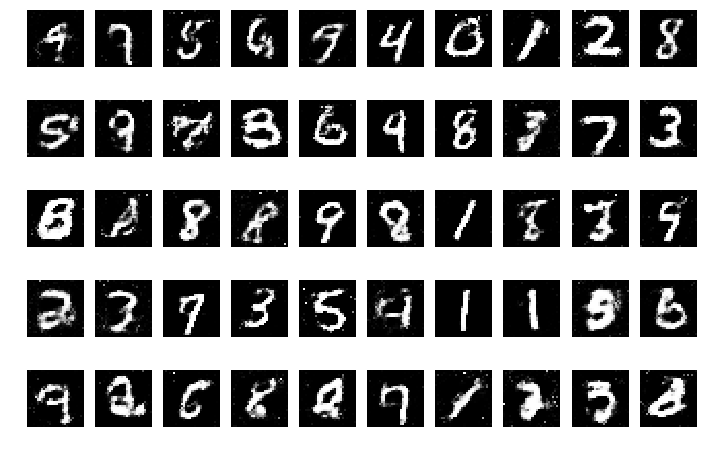

In [33]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
x = np.random.normal(0,1,(num_imgs,200))
img_pre = obj_gan.predict(x)
fig = plt.figure(figsize=(12,8))
print("-- Imagens geradas pelo Gerador da GAN--")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(img_pre[i].reshape(28,28), cmap = plt.cm.Greys_r)
    ax.axis("off")

In [34]:
sum(img_pre[5].reshape(28,28)**2)

array([27.728262, 27.98293 , 27.889154, 27.98958 , 27.970339, 27.871832,
       25.879253, 26.242756, 27.253748, 27.088484, 24.251432, 25.015354,
       23.493912, 24.7637  , 23.067633, 25.450073, 24.514065, 25.25473 ,
       24.909498, 26.492777, 25.013596, 26.282314, 27.304384, 27.932129,
       27.956646, 27.893448, 27.995722, 27.991869], dtype=float32)

In [35]:
a = (img_pre[0].reshape(28,28)/np.sqrt(np.sum(img_pre[0].reshape(28,28)**2)))
b = (img_pre[1].reshape(28,28)/np.sqrt(np.sum(img_pre[1].reshape(28,28)**2)))

In [36]:
print("similaridade")
sum(np.ravel(a*b))

similaridade


0.861840688272423